# Reddit Text Analysis of Medicare and Medicaid Posts

This notebook presents an analysis of Reddit posts from the **Medicare** and **Medicaid** subreddits. We perform clustering using **KMeans** and topic modeling using **Latent Dirichlet Allocation (LDA)** to uncover themes and patterns in user discussions.

---

## Contents

1. **Imports and Global Setup** – Load libraries, datasets, and feature matrices.  
2. **Data Preprocessing** – Check for empty posts and standardize numeric features.  
3. **KMeans Clustering** – Evaluate optimal cluster number and summarize clusters with top TF-IDF terms and numeric features.  
4. **LDA Topic Modeling** – Fit LDA models to identify topics and extract top terms per topic.  
5. **Cluster-Topic Comparison** – Compare KMeans clusters to LDA topics to assess correspondence.  
6. **Visualization** – PCA-based cluster plots and heatmaps.
7. **Export Data for Dashboard** - Prepare and export all necessary data for the Shiny app looking at Medicare results. 

---

### Important Note on Reproducibility

Because the underlying Reddit data is scraped from live subreddits, the results in this notebook **may vary slightly each time the code is run**. Differences may occur due to:

- New posts being added to subreddits.
- Removed or deleted posts.
- Changes in comment counts or scores.

All code is fully reproducible **given the same downloaded dataset and feature matrices** saved in the `../data/` folder. However, running the scraper again may yield updated or additional posts, which will affect the clustering and topic modeling results.


## Imports and Global Setup

In [1]:
# Import Statements

# Basic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
import os
import re

# Clustering
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix, load_npz, save_npz
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter, defaultdict



## Read in Data

In [2]:
df_medicaid = pd.read_csv("../data/processed_medicaid_data.csv")

In [3]:
df_medicare = pd.read_csv("../data/processed_medicare_data.csv")

In [4]:
tfidf_matrix_medicaid = load_npz("../data/tfidf_medicaid.npz")

In [5]:
tfidf_matrix_medicare = load_npz("../data/tfidf_medicare.npz")

In [6]:
# Read the feature names CSV
features_medicaid = pd.read_csv("../data/medicaid_tfidf_feature_names.csv", header=None).squeeze().tolist()

In [7]:
# Read the feature names CSV
features_medicare = pd.read_csv("../data/medicare_tfidf_feature_names.csv", header=None).squeeze().tolist()

In [8]:
numeric_cols = ['score', 'num_comments', 'text_length', 'word_count']

## Functions

In [9]:
def kmeans_evaluation(X, k_range=range(2,11)):
    """
    Evaluate KMeans clustering performance across a range of cluster sizes.

    Computes and plots the sum of squared errors (SSE) and silhouette scores
    for each value of k, and returns a summary DataFrame to aid in selecting
    the optimal number of clusters.
    """
    sse = []
    silhouette_scores = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        sse.append(km.inertia_)
        
        if k > 1:
            score = silhouette_score(X, km.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(None)
    
    # Plot SSE and Silhouette
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(list(k_range), sse, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("SSE (Inertia)")
    plt.title("KMeans: Elbow Method")
    
    plt.subplot(1,2,2)
    plt.plot(list(k_range), silhouette_scores, marker='o', color='orange')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("KMeans: Silhouette Scores")
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame({
        "k": list(k_range),
        "SSE": sse,
        "Silhouette": silhouette_scores
    })

In [10]:
def get_top_terms_per_cluster(X_tfidf, labels, feature_names, top_n=15):
    """
    Identify the top TF-IDF terms for each cluster based on average term weights.

    For each cluster, computes the mean TF-IDF score across all documents in the
    cluster and returns the top N terms with the highest average weights.
    """
    cluster_terms = {}
    for cluster in np.unique(labels):
        # Get indices of documents in this cluster
        cluster_idx = np.where(labels == cluster)[0]
        # Mean TF-IDF for each term in this cluster
        mean_tfidf = X_tfidf[cluster_idx].mean(axis=0)
        # Get top N terms
        top_idx = mean_tfidf.argsort()[::-1][:top_n]
        top_words = [(feature_names[i], mean_tfidf[i]) for i in top_idx]
        cluster_terms[cluster] = top_words
    return cluster_terms

In [11]:
def cluster_report(
    df,
    X_tfidf,
    feature_names,
    numeric_features,
    top_n=15
):
    """
    Generate a visual summary for each cluster:
    - Number of posts
    - Top TF-IDF terms (table)
    - Numeric feature distributions (plots)
    """

    for cluster in sorted(df["cluster"].unique()):
        print(f"\n==============================")
        print(f"Cluster {cluster}")
        print(f"==============================")

        cluster_mask = df["cluster"] == cluster
        cluster_idx = np.where(cluster_mask)[0]
        n_posts = cluster_mask.sum()

        print(f"Number of posts: {n_posts}")

        # --- Top TF-IDF terms ---
        mean_tfidf = X_tfidf[cluster_idx].mean(axis=0)
        top_idx = mean_tfidf.argsort()[::-1][:top_n]

        feature_names_arr = np.asarray(feature_names)

        top_terms_df = pd.DataFrame({
            "term": feature_names_arr[top_idx],
            "mean_tfidf": mean_tfidf[top_idx]
        }).round(4)

        print("\nTop TF-IDF terms:")
        display(top_terms_df)

        # --- Numeric feature plots ---
        if numeric_features:
            fig, axes = plt.subplots(
                1,
                len(numeric_features),
                figsize=(5 * len(numeric_features), 4),
                sharey=False
            )

            if len(numeric_features) == 1:
                axes = [axes]

            for ax, col in zip(axes, numeric_features):
                sns.histplot(
                    df.loc[cluster_mask, col],
                    bins=25,
                    kde=True,
                    ax=ax
                )
                ax.set_title(f"{col}")
                ax.set_xlabel(col)
                ax.set_ylabel("Posts")

            fig.suptitle(f"Numeric Feature Distributions — Cluster {cluster}", fontsize=16)
            plt.tight_layout()
            plt.show()

In [12]:
# Function to get top terms per topic 
def get_top_terms_per_topic(lda_model, feature_names, top_n=15):
    """
    Extract the top terms for each LDA topic based on word–topic weights.

    For each topic, identifies the top N terms with the highest weights in the
    LDA model and returns them as a DataFrame for easy inspection and comparison
    across topics.
    """
    topics = {}

    for topic_idx, topic_weights in enumerate(lda_model.components_):
        top_idx = topic_weights.argsort()[::-1][:top_n]

        topics[topic_idx] = pd.DataFrame({
            "term": feature_names[top_idx],
            "weight": topic_weights[top_idx]
        }).round(4)

    return topics

## Medicaid Clustering Analysis

### Standardize Numeric Columns

In [13]:
# Standardize Numeric Columns
scaler = StandardScaler()
X_num_scaled_medicaid = scaler.fit_transform(df_medicaid[numeric_cols])

In [14]:
# Convert scaled numeric features to sparse and concatenate
X_combined_medicaid = hstack([tfidf_matrix_medicaid, csr_matrix(X_num_scaled_medicaid)])

print("Combined feature matrix shape:", X_combined_medicaid.shape)

Combined feature matrix shape: (660, 696)


### Selection of k

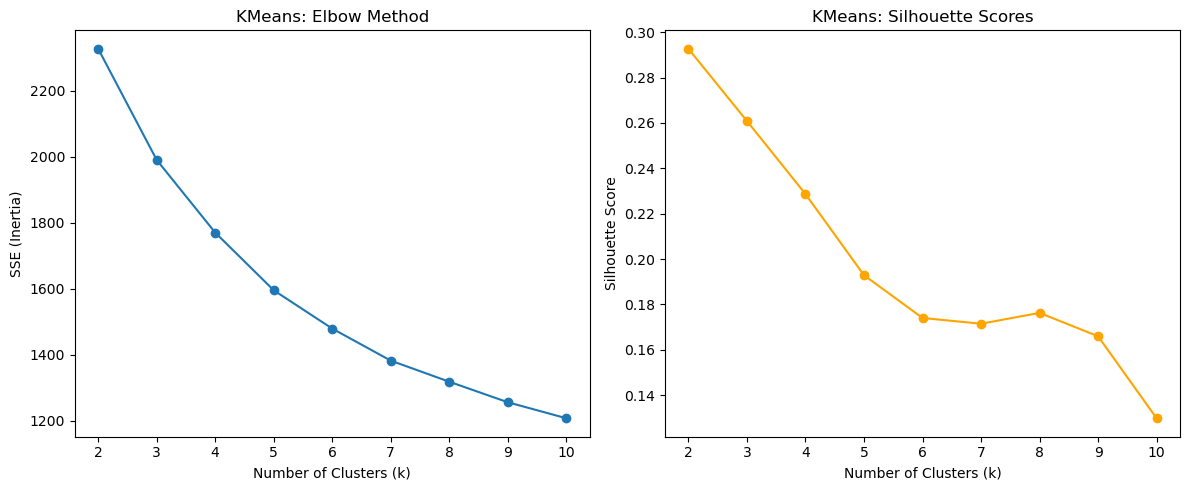

    k          SSE  Silhouette
0   2  2326.752895    0.292698
1   3  1989.997002    0.260854
2   4  1769.843084    0.228675
3   5  1595.153227    0.192893
4   6  1478.983818    0.174044
5   7  1381.952476    0.171498
6   8  1318.025614    0.176287
7   9  1255.874292    0.165963
8  10  1207.407332    0.129831


In [15]:
# Run evaluation
kmeans_metrics_medicaid = kmeans_evaluation(X_combined_medicaid, k_range=range(2,11))
print(kmeans_metrics_medicaid)

**Analysis**

Based on the KMeans evaluation for the Medicaid subreddit using the combined TF-IDF and numeric features:

The SSE (inertia) decreases as the number of clusters k increases, showing that adding clusters reduces within-cluster variance.

The SSE scores are high across all values of k and the silhouette scores are low across all values of k. This is expected with highly-sparse and messy text data and does not mean that we cannot proceed with the analysis. 

The Silhouette score is highest at k = 2 (0.293), but k = 4 still maintains a relatively high score (0.224), indicating that clusters remain reasonably well-separated.

Choosing k = 4 provides a balance between interpretability and granularity, allowing us to capture additional thematic distinctions in the posts while keeping clusters meaningful. This gives more detailed insights into the discussion topics and post characteristics than a 2-cluster solution.

### Kmeans

In [16]:
# Use chosen k to fit KMeans object
k_medicaid = 4
km_medicaid = KMeans(n_clusters=k_medicaid, random_state=42, n_init=10)
km_medicaid.fit(X_combined_medicaid)

# Assign cluster labels to df_medicaid
df_medicaid['cluster'] = km_medicaid.labels_
print(df_medicaid['cluster'].value_counts())

cluster
1    326
2    161
3     92
0     81
Name: count, dtype: int64


In [17]:
# Extract only TF-IDF weights (exclude numeric features)
X_tfidf_only_medicaid = tfidf_matrix_medicaid.toarray()

In [18]:
# Get top features
top_terms_medicaid = get_top_terms_per_cluster(X_tfidf_only_medicaid, km_medicaid.labels_, features_medicaid, top_n=15)

In [19]:
# Display top terms
dfs = {}

for cluster, terms in top_terms_medicaid.items():
    df = pd.DataFrame(terms, columns=["Term", "Avg TF-IDF"])
    dfs[f"Cluster {cluster}"] = df["Term"]

display(pd.DataFrame(dfs))

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,navigate,nursing home,offered,nursing home
1,denied,term care,info,disability
2,oh,illinois,issue,kicked
3,day,couple,let,checked
4,missouri,owe,california,marketplace
5,treatment,il,cover,medically
6,appreciate,renew,website,california
7,hours,cover,receive medicaid,lives
8,carolina,ones,according,worker
9,difference,verification,area,oh


In [20]:
# Look at numeric variable summaries
cluster_summary_medicaid = (
    df_medicaid
    .groupby("cluster")[numeric_cols]
    .agg(["mean", "std", "min", "max"])
    .round(2)
)

display(cluster_summary_medicaid)

score               num_comments               text_length          \
         mean   std min max         mean   std min max        mean     std   
cluster                                                                      
0        4.79  0.98   3   6         8.26  5.57   0  23      699.67  321.61   
1        1.66  0.92   0   4         2.98  2.16   0   9      456.16  223.78   
2        1.76  1.34   0   6         6.15  5.17   0  22     1345.93  299.58   
3        1.37  1.13   0   4        13.90  4.87   8  24      498.21  258.20   

                   word_count                   
         min   max       mean    std  min  max  
cluster                                         
0        178  1367     126.43  59.50   16  266  
1         10   971      83.49  40.95    2  173  
2        903  2088     246.11  55.45  153  393  
3         65  1222      93.37  48.56    9  233

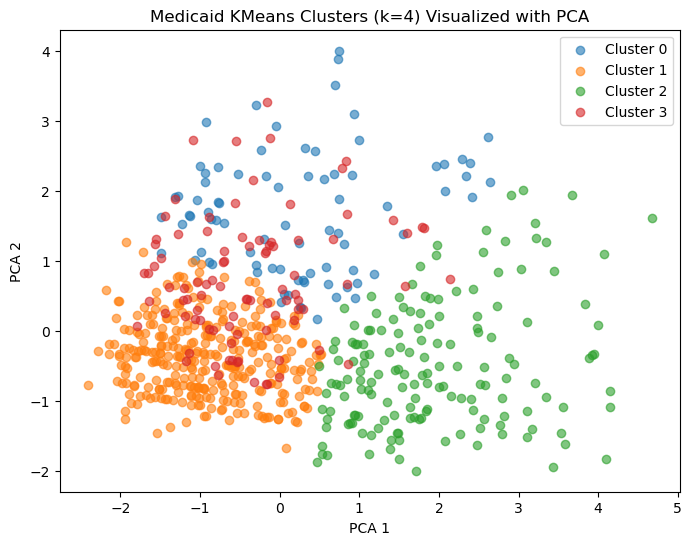

In [21]:
# Reduce TF-IDF + numeric features to 2D for visualization
pca_medicaid = PCA(n_components=2, random_state=42)
X_pca_medicaid = pca_medicaid.fit_transform(X_combined_medicaid.toarray())  # convert sparse to dense

plt.figure(figsize=(8,6))
for cluster in range(k_medicaid):
    plt.scatter(
        X_pca_medicaid[df_medicaid['cluster']==cluster, 0],
        X_pca_medicaid[df_medicaid['cluster']==cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Medicaid KMeans Clusters (k=4) Visualized with PCA")
plt.legend()
plt.savefig("../figures/medicaid_kmeans_pca.png")
plt.show()


Cluster 0
Number of posts: 81

Top TF-IDF terms:


,term,mean_tfidf
0,navigate,0.0328
1,denied,0.0326
2,oh,0.0279
3,day,0.0272
4,missouri,0.0246
5,treatment,0.0228
6,appreciate,0.0216
7,hours,0.0214
8,carolina,0.0209
9,difference,0.0202


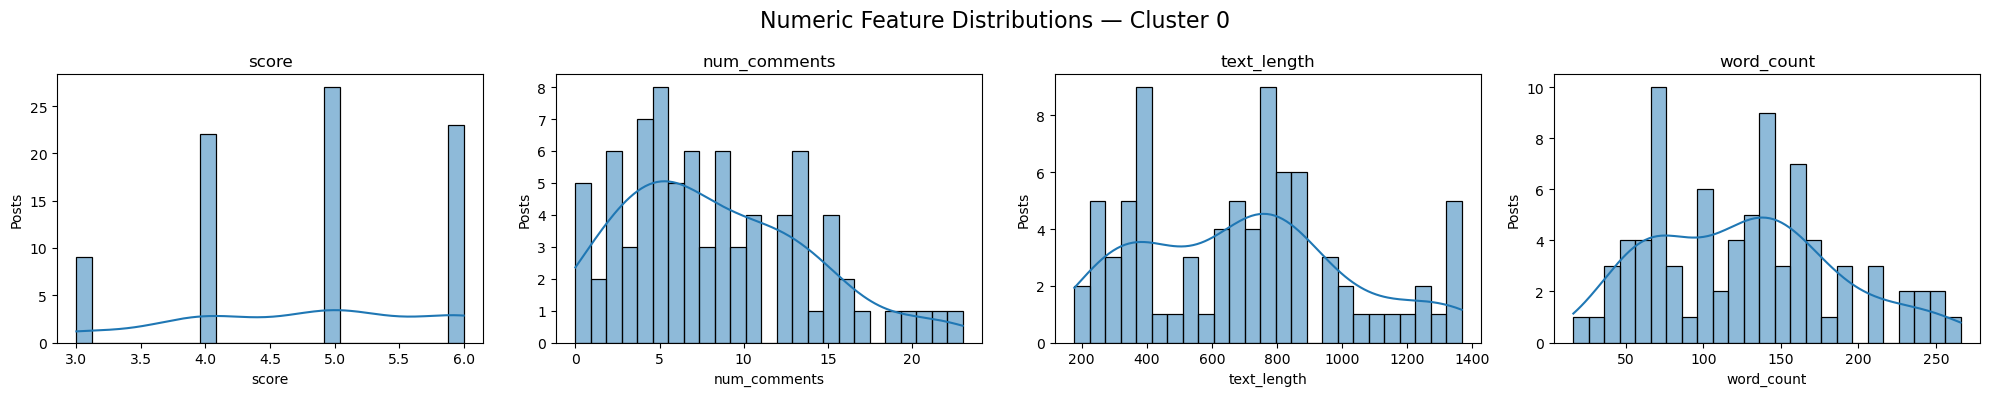


Cluster 1
Number of posts: 326

Top TF-IDF terms:


,term,mean_tfidf
0,nursing home,0.0233
1,term care,0.0222
2,illinois,0.0187
3,couple,0.0186
4,owe,0.0165
5,il,0.0165
6,renew,0.0163
7,cover,0.0161
8,ones,0.0157
9,verification,0.0157


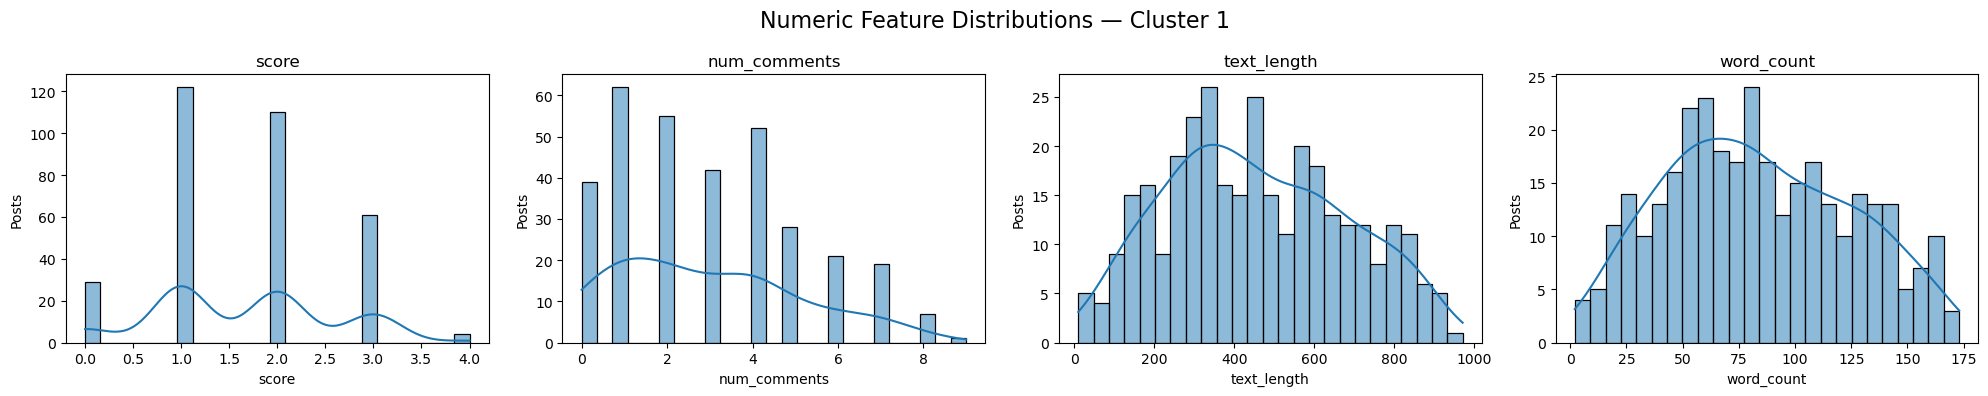


Cluster 2
Number of posts: 161

Top TF-IDF terms:


,term,mean_tfidf
0,offered,0.0274
1,info,0.0264
2,issue,0.0257
3,let,0.0249
4,california,0.0246
5,cover,0.0233
6,website,0.0230
7,receive medicaid,0.0226
8,according,0.0225
9,area,0.0221


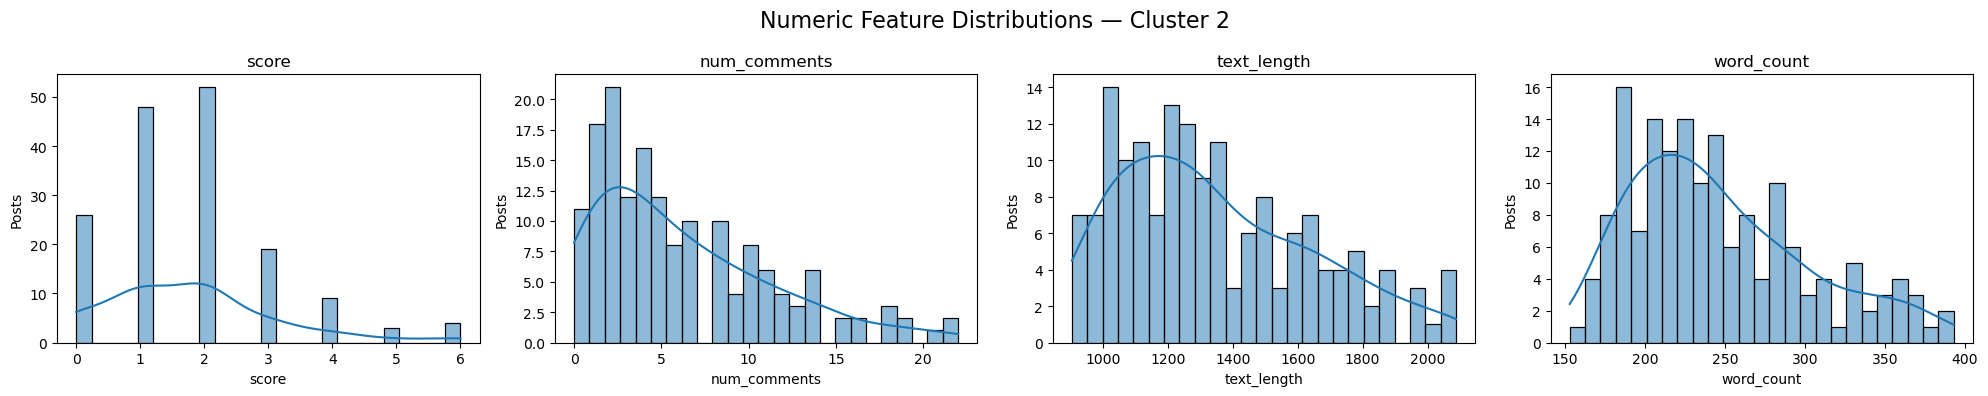


Cluster 3
Number of posts: 92

Top TF-IDF terms:


,term,mean_tfidf
0,nursing home,0.0408
1,disability,0.0320
2,kicked,0.0275
3,checked,0.0265
4,marketplace,0.0257
5,medically,0.0234
6,california,0.0233
7,lives,0.0223
8,worker,0.0196
9,oh,0.0192


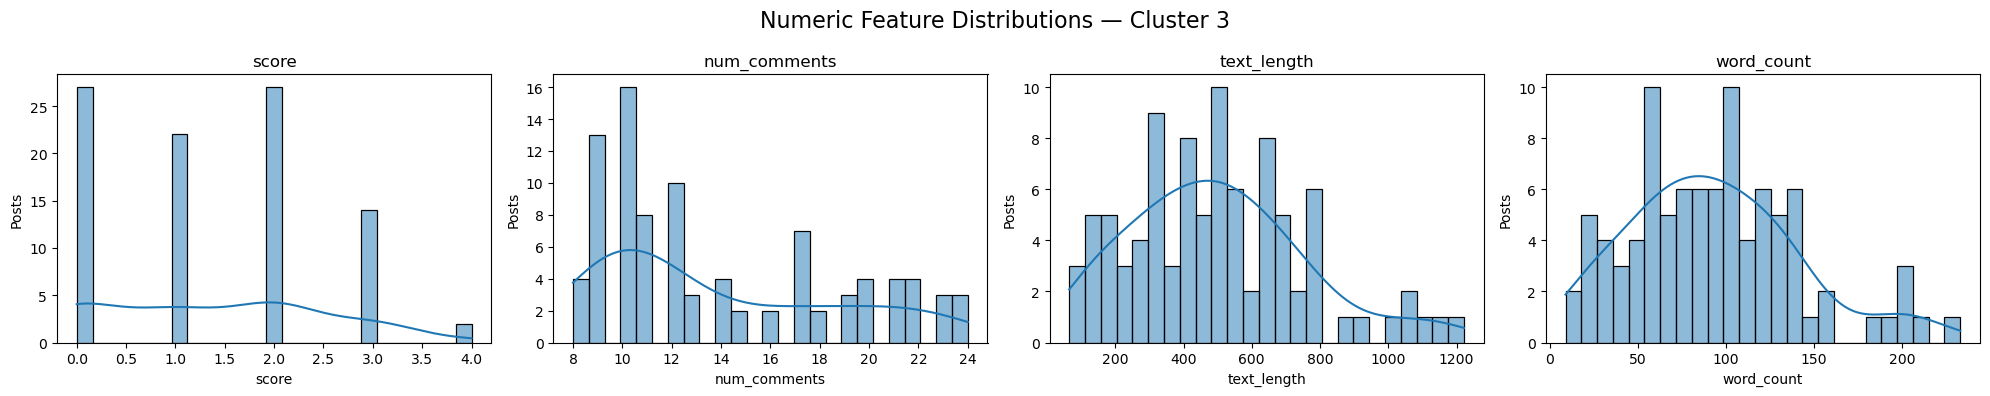

In [22]:
# Run the cluster report
cluster_info_medicaid = cluster_report(df_medicaid, X_tfidf_only_medicaid, features_medicaid, numeric_cols, top_n=15)

### Topic Modeling

In [23]:
# Fit LDA Count Vectorizer Using Same Parameters as KMeans
vectorizer_lda_medicaid = CountVectorizer(
    stop_words="english",
    min_df=10,
    max_df=0.10,
    ngram_range=(1, 2)
)

In [24]:
# Create count matrix and feature names
X_counts_medicaid = vectorizer_lda_medicaid.fit_transform(df_medicaid["clean_text"])
feature_names_medicaid = vectorizer_lda_medicaid.get_feature_names_out()

In [25]:
# Create model instance
lda_model_medicaid = LatentDirichletAllocation(
    n_components=k_medicaid,
    max_iter=20,
    learning_method="batch",
    random_state=42
)

In [26]:
# Fit model 
lda_model_medicaid.fit(X_counts_medicaid)

LatentDirichletAllocation(max_iter=20, n_components=4, random_state=42)

In [27]:
# Assign topics
topic_dist_medicaid = lda_model_medicaid.transform(X_counts_medicaid)
df_medicaid["lda_topic"] = topic_dist_medicaid.argmax(axis=1)

In [28]:
top_terms_lda_medicaid = get_top_terms_per_topic(
    lda_model_medicaid,
    feature_names_medicaid,
    top_n=15
)

In [29]:
numeric_cols = ["score", "num_comments", "text_length", "word_count"]

for topic in sorted(df_medicaid["lda_topic"].unique()):
    print("\n==============================")
    print(f"LDA Topic {topic}")
    print("==============================")

    topic_mask = df_medicaid["lda_topic"] == topic
    n_posts = topic_mask.sum()

    print(f"Number of posts: {n_posts}")
    print("\nTop terms:")
    display(top_terms_lda_medicaid[topic])

    topic_summary = (
        df_medicaid.loc[topic_mask, numeric_cols]
        .agg(["mean", "std", "min", "max"])
        .round(2)
    )

    print("Numeric summary:")
    display(topic_summary)



LDA Topic 0
Number of posts: 137

Top terms:


,term,weight
0,renewal,91.2107
1,household,60.2143
2,child,55.1324
3,medi,53.2409
4,medi cal,53.2409
5,cal,53.2409
6,kids,39.2211
7,texas,37.3199
8,form,36.7981
9,recently,32.5707


Numeric summary:


,score,num_comments,text_length,word_count
mean,1.77,4.96,550.93,100.77
std,1.34,4.93,361.29,66.08
min,0.00,0.00,10.00,2.00
max,6.00,24.00,1834.00,363.00



LDA Topic 1
Number of posts: 210

Top terms:


,term,weight
0,letter,83.7175
1,office,65.0895
2,called,62.6852
3,information,57.1339
4,received,55.1277
5,card,55.1097
6,im,53.9460
7,applied,53.5877
8,days,51.4440
9,week,49.9045


Numeric summary:


,score,num_comments,text_length,word_count
mean,2.03,5.31,761.79,139.73
std,1.47,5.12,466.97,86.51
min,0.00,0.00,29.00,6.00
max,6.00,22.00,2084.00,392.00



LDA Topic 2
Number of posts: 163

Top terms:


,term,weight
0,mom,67.6746
1,nursing,66.0839
2,issues,63.2304
3,old,52.7334
4,needs,52.5596
5,mother,51.7608
6,facility,50.8311
7,term,49.7115
8,trust,44.2373
9,house,43.9767


Numeric summary:


,score,num_comments,text_length,word_count
mean,2.30,6.93,793.55,146.24
std,1.59,5.74,450.60,83.27
min,0.00,0.00,25.00,4.00
max,6.00,23.00,2088.00,393.00



LDA Topic 3
Number of posts: 150

Top terms:


,term,weight
0,disabled,66.0760
1,ny,64.3733
2,monthly,64.1169
3,ssi,46.1641
4,program,45.7709
5,social,42.0273
6,denied,38.8525
7,ssdi,37.8898
8,looking,35.6228
9,parents,32.7016


Numeric summary:


,score,num_comments,text_length,word_count
mean,1.97,6.56,687.38,124.57
std,1.53,5.81,476.04,84.69
min,0.00,0.00,96.00,17.00
max,6.00,24.00,2020.00,364.00


### Comparison

In [30]:
# Correspondence table
medicaid_correspondence = pd.crosstab(df_medicaid['cluster'], df_medicaid['lda_topic'], 
                             rownames=['KMeans Cluster'], colnames=['LDA Topic'])
print("\nCluster-Topic Correspondence:")
print(medicaid_correspondence)


Cluster-Topic Correspondence:
LDA Topic        0    1   2   3
KMeans Cluster                 
0               12   26  26  17
1               90  104  63  69
2               19   61  48  33
3               16   19  26  31


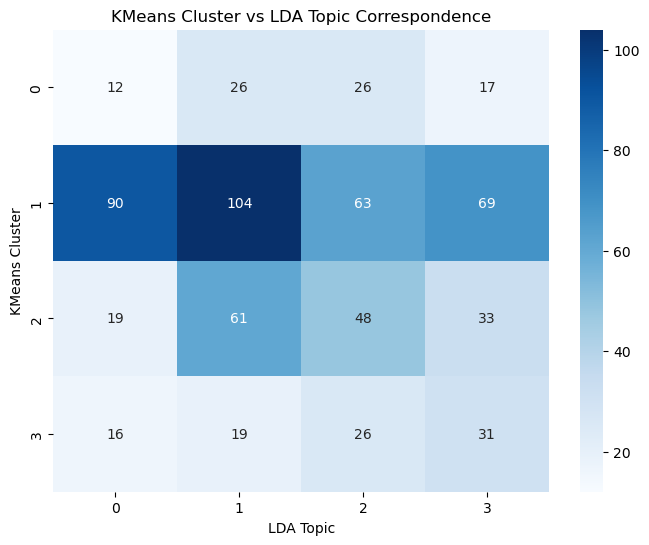

In [31]:
# Heatmap of cluster-topic correspondence
plt.figure(figsize=(8, 6))
sns.heatmap(medicaid_correspondence, annot=True, fmt='d', cmap='Blues')
plt.title("KMeans Cluster vs LDA Topic Correspondence")
plt.savefig("../figures/medicaid_correspondence_heatmap.png")
plt.show()

## Medicare Clustering Analysis

### Standardize Numeric Columns

In [32]:
# Standardize Numeric Columns
scaler = StandardScaler()
X_num_scaled_medicare = scaler.fit_transform(df_medicare[numeric_cols])

In [33]:
# Convert scaled numeric features to sparse and concatenate
X_combined_medicare = hstack([tfidf_matrix_medicare, csr_matrix(X_num_scaled_medicare)])

print("Combined feature matrix shape:", X_combined_medicare.shape)

Combined feature matrix shape: (590, 552)


### Selection of k

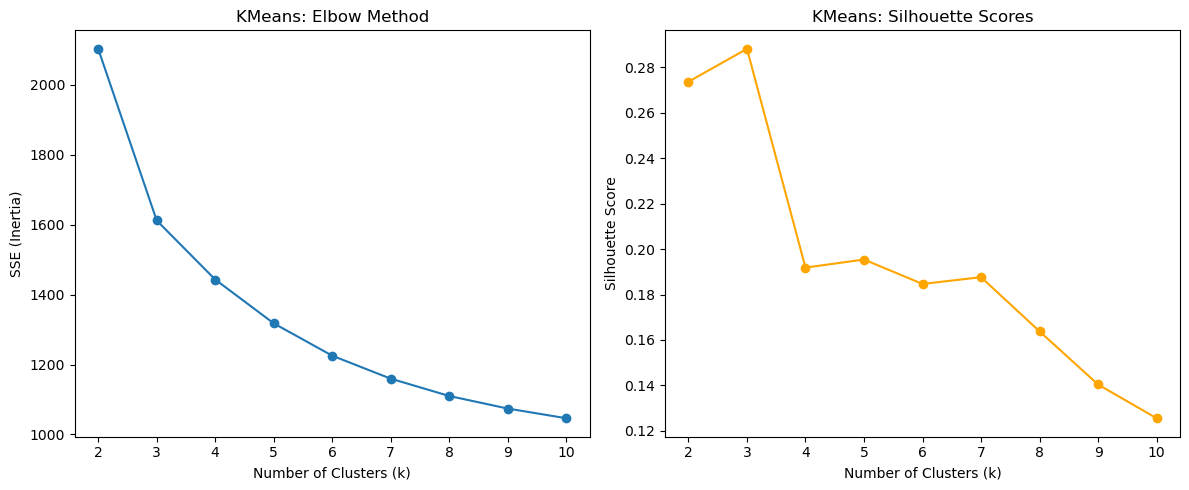

    k          SSE  Silhouette
0   2  2102.149779    0.273544
1   3  1611.531805    0.288040
2   4  1442.803063    0.191831
3   5  1317.595891    0.195375
4   6  1225.112605    0.184647
5   7  1159.505556    0.187621
6   8  1109.994403    0.163802
7   9  1074.075865    0.140431
8  10  1046.429837    0.125591


In [34]:
# Run evaluation
kmeans_metrics_medicare = kmeans_evaluation(X_combined_medicare, k_range=range(2,11))
print(kmeans_metrics_medicare)

**Analysis**

Based on the KMeans evaluation for the Medicare subreddit using the combined TF-IDF and numeric features:

The SSE (inertia) decreases as the number of clusters k increases, showing that adding clusters reduces within-cluster variance. 

The Silhouette score is highest at k = 3 (0.288), which corresponds to an elbow in the SSE plot.

Choosing k = 3 provides a balance between interpretability and granularity, allowing us to capture additional thematic distinctions in the posts while keeping clusters meaningful. 

### Kmeans

In [35]:
# Use chosen k to fit KMeans object
k_medicare = 3
km_medicare = KMeans(n_clusters=k_medicare, random_state=42, n_init=10)
km_medicare.fit(X_combined_medicare)

# Assign cluster labels to df_medicaid
df_medicare['cluster'] = km_medicare.labels_
print(df_medicare['cluster'].value_counts())

cluster
1    326
0    141
2    123
Name: count, dtype: int64


In [36]:
# Extract only TF-IDF weights (exclude numeric features)
X_tfidf_only_medicare = tfidf_matrix_medicare.toarray()

In [37]:
# Get top features
top_terms_medicare = get_top_terms_per_cluster(X_tfidf_only_medicare, km_medicare.labels_, features_medicare, top_n=15)

In [38]:
# Display top terms
dfs = {}

for cluster, terms in top_terms_medicare.items():
    df = pd.DataFrame(terms, columns=["Term", "Avg TF-IDF"])
    dfs[f"Cluster {cluster}"] = df["Term"]

display(pd.DataFrame(dfs))

,Cluster 0,Cluster 1,Cluster 2
0,means,interested,decided
1,decided,means,medications
2,uhc,course,drop
3,card,benefit,monthly premium
4,receive,secondary,surgery
5,interested,social,eligible medicare
6,cancer,small,option
7,major,hoping,supplement plan
8,ss,drop,july
9,supposed,card,jan


In [39]:
# Look at numeric variable summaries
cluster_summary_medicare = (
    df_medicare
    .groupby("cluster")[numeric_cols]
    .agg(["mean", "std", "min", "max"])
    .round(2)
)

display(cluster_summary_medicare)

score               num_comments                text_length          \
         mean   std min max         mean    std min max        mean     std   
cluster                                                                       
0        2.83  2.26   0  11        13.11   9.46   0  45     1206.40  248.19   
1        2.14  1.60   0   8         8.95   6.58   0  32      432.07  206.83   
2        7.12  3.11   0  13        28.86  12.26   5  53      552.20  240.14   

                   word_count                   
         min   max       mean    std  min  max  
cluster                                         
0        805  1783     214.93  46.00  120  328  
1         39   961      77.35  36.13    7  161  
2         47  1195      99.83  44.97   10  220

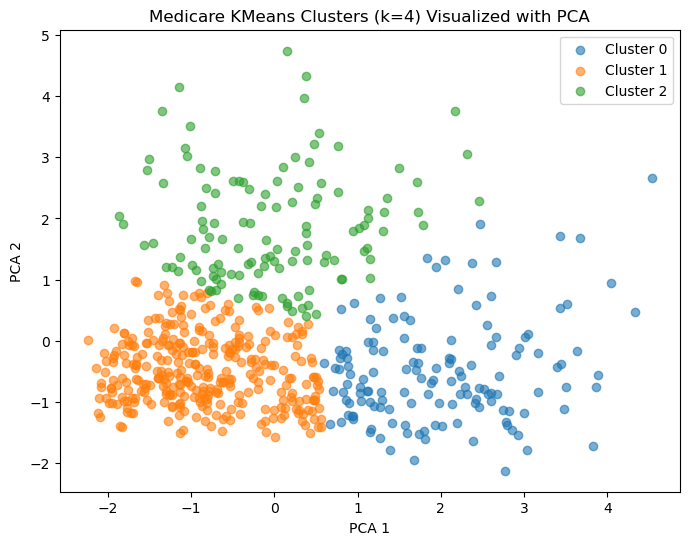

In [40]:
# Reduce TF-IDF + numeric features to 2D for visualization
pca_medicare = PCA(n_components=2, random_state=42)
X_pca_medicare = pca_medicare.fit_transform(X_combined_medicare.toarray())  # convert sparse to dense

plt.figure(figsize=(8,6))
for cluster in range(k_medicare):
    plt.scatter(
        X_pca_medicare[df_medicare['cluster']==cluster, 0],
        X_pca_medicare[df_medicare['cluster']==cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Medicare KMeans Clusters (k=4) Visualized with PCA")
plt.legend()
plt.savefig("../figures/medicare_kmeans_pca.png")
plt.show()


Cluster 0
Number of posts: 141

Top TF-IDF terms:


,term,mean_tfidf
0,means,0.0419
1,decided,0.0300
2,uhc,0.0266
3,card,0.0265
4,receive,0.0256
5,interested,0.0241
6,cancer,0.0236
7,major,0.0229
8,ss,0.0223
9,supposed,0.0222


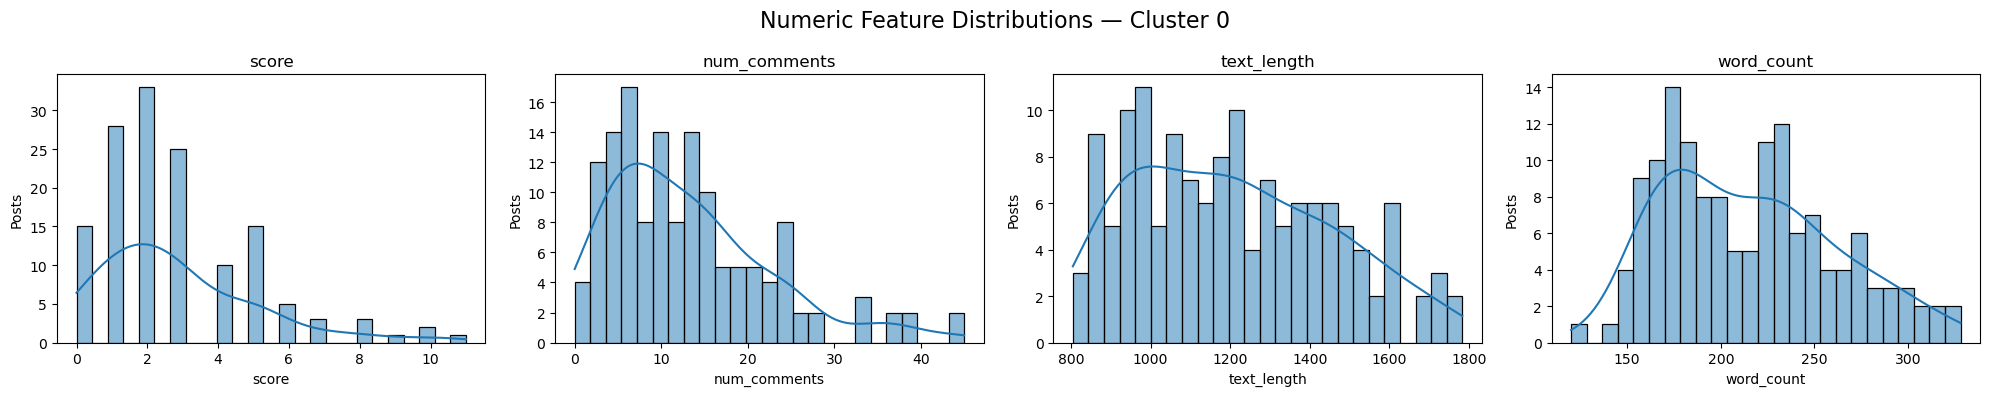


Cluster 1
Number of posts: 326

Top TF-IDF terms:


,term,mean_tfidf
0,interested,0.0233
1,means,0.0220
2,course,0.0182
3,benefit,0.0178
4,secondary,0.0177
5,social,0.0177
6,small,0.0176
7,hoping,0.0164
8,drop,0.0162
9,card,0.0160


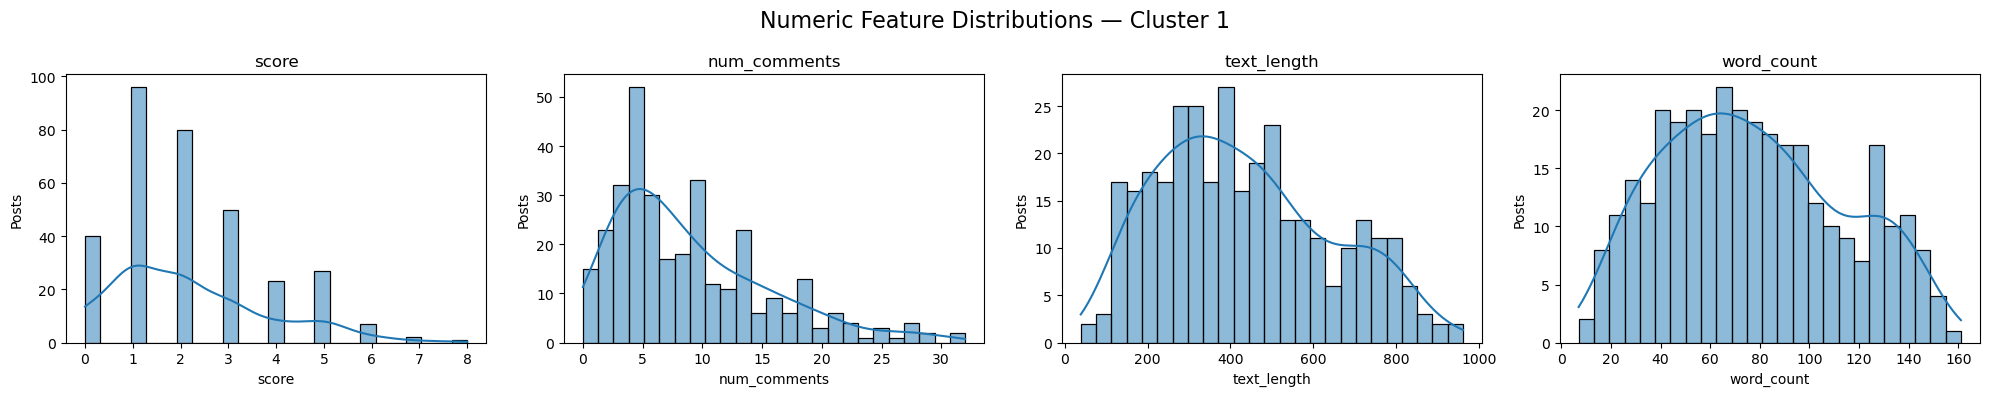


Cluster 2
Number of posts: 123

Top TF-IDF terms:


,term,mean_tfidf
0,decided,0.0415
1,medications,0.0281
2,drop,0.0278
3,monthly premium,0.0274
4,surgery,0.0256
5,eligible medicare,0.0231
6,option,0.0226
7,supplement plan,0.0220
8,july,0.0218
9,jan,0.0215


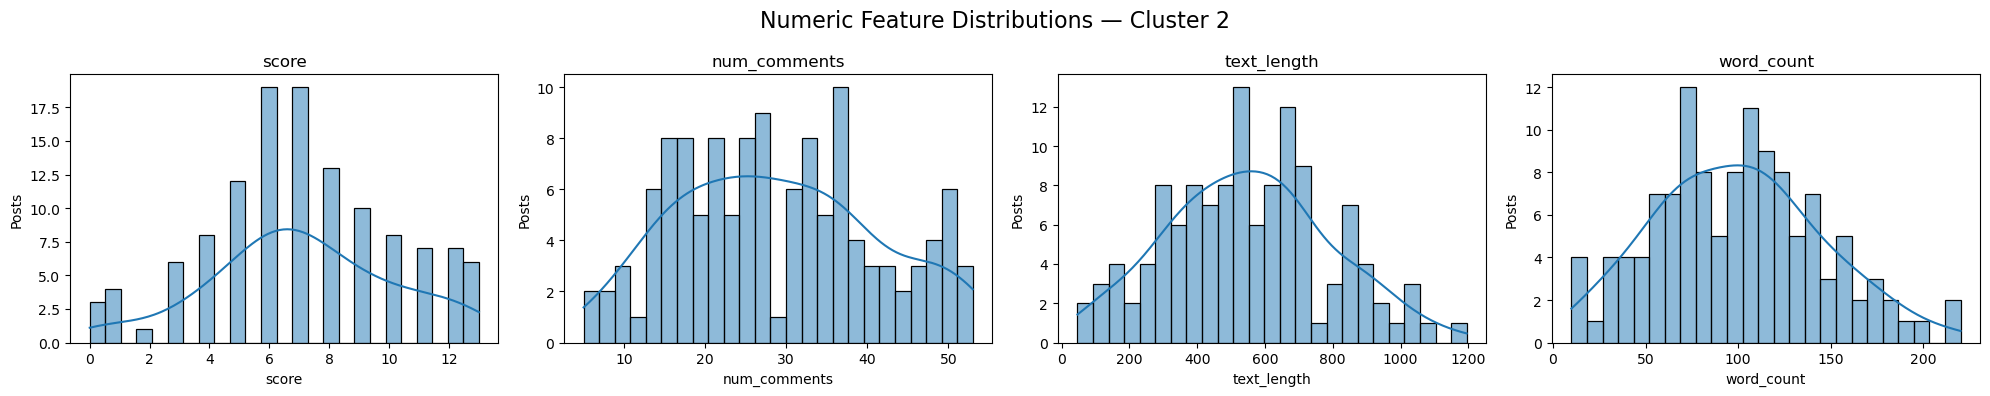

In [41]:
# Run the cluster report
cluster_info_medicare = cluster_report(df_medicare, X_tfidf_only_medicare, features_medicare, numeric_cols, top_n=15)

### Topic Modeling

In [42]:
# Fit LDA Count Vectorizer Using Same Parameters as KMeans
vectorizer_lda_medicare = CountVectorizer(
    stop_words="english",
    min_df=10,
    max_df=0.10,
    ngram_range=(1, 2)
)

In [43]:
# Create count matrix and feature names
X_counts_medicare = vectorizer_lda_medicare.fit_transform(df_medicare["clean_text"])
feature_names_medicare = vectorizer_lda_medicare.get_feature_names_out()

In [44]:
# Create model instance
lda_model_medicare = LatentDirichletAllocation(
    n_components=k_medicare,
    max_iter=20,
    learning_method="batch",
    random_state=42
)

In [45]:
# Fit model 
lda_model_medicare.fit(X_counts_medicare)

LatentDirichletAllocation(max_iter=20, n_components=3, random_state=42)

In [46]:
# Assign topics
topic_dist_medicare = lda_model_medicare.transform(X_counts_medicare)
df_medicare["lda_topic"] = topic_dist_medicare.argmax(axis=1)

In [47]:
top_terms_lda_medicare = get_top_terms_per_topic(
    lda_model_medicare,
    feature_names_medicare,
    top_n=15
)

In [48]:
numeric_cols = ["score", "num_comments", "text_length", "word_count"]

for topic in sorted(df_medicare["lda_topic"].unique()):
    print("\n==============================")
    print(f"LDA Topic {topic}")
    print("==============================")

    topic_mask = df_medicare["lda_topic"] == topic
    n_posts = topic_mask.sum()

    print(f"Number of posts: {n_posts}")
    print("\nTop terms:")
    display(top_terms_lda_medicare[topic])

    topic_summary = (
        df_medicare.loc[topic_mask, numeric_cols]
        .agg(["mean", "std", "min", "max"])
        .round(2)
    )

    print("Numeric summary:")
    display(topic_summary)



LDA Topic 0
Number of posts: 172

Top terms:


,term,weight
0,irmaa,92.3227
1,employer,68.3906
2,social,66.3155
3,security,65.3174
4,social security,65.3174
5,ssa,64.3099
6,medicaid,56.9776
7,letter,56.1054
8,penalty,50.1477
9,enrolled,48.5181


Numeric summary:


,score,num_comments,text_length,word_count
mean,3.1,12.07,675.92,122.69
std,2.7,10.68,410.97,73.85
min,0.0,0.00,73.00,10.00
max,13.0,53.00,1783.00,328.00



LDA Topic 1
Number of posts: 213

Top terms:


,term,weight
0,deductible,84.1828
1,drug,79.8089
2,cover,69.8051
3,drugs,57.2186
4,doctor,56.1349
5,provider,52.6916
6,humana,52.6002
7,hospital,50.2886
8,costs,49.9637
9,paid,49.8214


Numeric summary:


,score,num_comments,text_length,word_count
mean,3.44,15.07,624.97,109.13
std,2.90,12.68,388.25,67.86
min,0.00,0.00,39.00,7.00
max,13.00,53.00,1734.00,319.00



LDA Topic 2
Number of posts: 205

Top terms:


,term,weight
0,gov,60.0387
1,card,52.5188
2,medigap plan,51.7758
3,switch,51.3266
4,medicare gov,50.2813
5,bcbs,50.2644
6,mom,49.9916
7,issue,49.6935
8,went,44.8298
9,underwriting,40.2702


Numeric summary:


,score,num_comments,text_length,word_count
mean,3.44,14.78,631.71,114.40
std,3.08,11.26,375.20,67.85
min,0.00,0.00,75.00,13.00
max,13.00,51.00,1748.00,305.00


### Comparison

In [49]:
# Correspondence table
medicare_correspondence = pd.crosstab(df_medicare['cluster'], df_medicare['lda_topic'], 
                             rownames=['KMeans Cluster'], colnames=['LDA Topic'])
print("\nCluster-Topic Correspondence:")
print(medicare_correspondence)


Cluster-Topic Correspondence:
LDA Topic         0    1    2
KMeans Cluster               
0                44   46   51
1               101  116  109
2                27   51   45


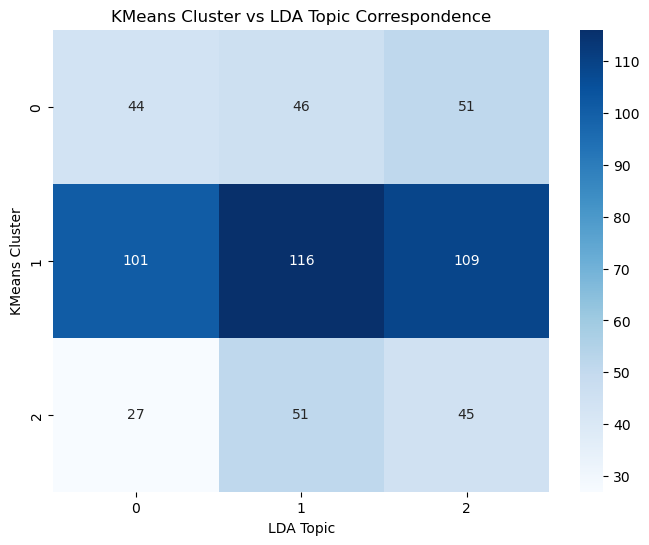

In [50]:
# Heatmap of cluster-topic correspondence
plt.figure(figsize=(8, 6))
sns.heatmap(medicare_correspondence, annot=True, fmt='d', cmap='Blues')
plt.title("KMeans Cluster vs LDA Topic Correspondence")
plt.savefig("../figures/medicare_correspondence_heatmap.png")
plt.show()

## Figures

In [51]:
# Set plotting style
sns.set_style("whitegrid")
sns.set_context("talk")  # larger fonts

### Functions

In [52]:
def plot_token_doc_frequency(df, text_column="clean_text", program_name="Medicaid", min_df=10):
    """
    Plots distribution of token document frequencies for a given program.
    """
    texts = df[text_column].tolist()
    
    # CountVectorizer to get raw counts
    count_vect = CountVectorizer(stop_words='english', min_df=min_df)
    X_counts = count_vect.fit_transform(texts)
    
    # Document frequency for each token
    doc_freq = (X_counts > 0).sum(axis=0).A1  # number of posts each token appears in
    num_posts = len(texts)
    
    # Convert to proportion
    doc_freq_prop = doc_freq / num_posts
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.histplot(doc_freq_prop, bins=50, color='lightcoral')
    plt.title(f"{program_name}: Distribution of Token Document Frequencies", fontsize=18)
    plt.xlabel("Proportion of Posts Token Appears In", fontsize=14)
    plt.ylabel("Number of Tokens", fontsize=14)
    plt.tight_layout()
    
    # Save figure
    filename = f"../figures/{program_name.lower()}_token_doc_freq.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

In [53]:
def kmeans_elbow_silhouette(X, program_name="Medicaid", k_range=range(2,11)):
    """
    Computes KMeans SSE (inertia) and silhouette scores for a range of clusters,
    and plots both in a combined figure.
    """
    sse = []
    silhouette_scores = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        sse.append(km.inertia_)
        if k > 1:
            score = silhouette_score(X, km.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(None)
    

    plt.figure(figsize=(12,5))

    # Elbow plot
    plt.subplot(1,2,1)
    plt.plot(list(k_range), sse, marker='o', color='skyblue')
    plt.xlabel("Number of Clusters (k)", fontsize=14)
    plt.ylabel("SSE (Inertia)", fontsize=14)
    plt.title(f"{program_name}: KMeans Elbow Method", fontsize=16)

    # Silhouette plot
    plt.subplot(1,2,2)
    plt.plot(list(k_range), silhouette_scores, marker='o', color='orange')
    plt.xlabel("Number of Clusters (k)", fontsize=14)
    plt.ylabel("Silhouette Score", fontsize=14)
    plt.title(f"{program_name}: KMeans Silhouette Scores", fontsize=16)

    plt.tight_layout()
    
    # Save figure
    filename = f"../figures/{program_name.lower()}_kmeans_eval.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

In [54]:
def plot_posts_by_topic(df, topic_col='lda_topic', program_name="Medicaid"):
    """
    Plots the number of posts per LDA topic for a given program.
    """
    

    # Count posts per topic
    topic_counts = df[topic_col].value_counts().sort_index()

    plt.figure(figsize=(8,6))
    # Use 'color' instead of 'palette' to avoid the warning
    sns.barplot(x=topic_counts.index, y=topic_counts.values, color="steelblue")
    
    plt.xlabel("Topic", fontsize=14)
    plt.ylabel("Number of Posts", fontsize=14)
    plt.title(f"{program_name}: Number of Posts by LDA Topic", fontsize=16)
    
    # Annotate bars with counts
    for i, v in enumerate(topic_counts.values):
        plt.text(i, v + max(topic_counts.values)*0.01, str(v), ha='center', fontsize=12)
    
    plt.tight_layout()
    
    # Save figure
    filename = f"../figures/{program_name.lower()}_posts_by_topic.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

In [55]:
def fit_lda_and_plot(df, program_name="Medicaid", n_topics=4, n_top_words=10, save=True):
    """
    Fit LDA on clean_text and plot top words per topic.

    Parameters:
        df: DataFrame containing 'clean_text' column
        program_name: 'Medicaid' or 'Medicare'
        n_topics: Number of LDA topics to fit
        n_top_words: Number of top words to plot per topic
        save: Whether to save the figure
    """
    # Step 1: Count matrix
    vectorizer_lda = CountVectorizer(
        stop_words='english',
        min_df=10,
        max_df=0.10,
        ngram_range=(1,2)
    )
    X_counts = vectorizer_lda.fit_transform(df['clean_text'])
    feature_names = vectorizer_lda.get_feature_names_out()

    # Step 2: Fit LDA
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=20,
        learning_method='batch',
        random_state=42
    )
    lda_model.fit(X_counts)

    # Step 3: Print top words
    print(f"\nTop words per topic for {program_name}:\n")
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        print(f"===== Topic {topic_idx} =====")
        for word, weight in zip(top_words, top_weights):
            print(f"{word} ({weight:.4f})")
        print("\n")

    # Step 4: Assign topics to posts
    topic_dist = lda_model.transform(X_counts)
    df['lda_topic'] = topic_dist.argmax(axis=1)

    # Step 5: Plot top words per topic
    fig, axes = plt.subplots(n_topics, 1, figsize=(10, 4*n_topics), sharex=False)
    if n_topics == 1:
        axes = [axes]

    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]

        # Replace palette with color to remove FutureWarning
        sns.barplot(x=top_weights, y=top_words, ax=axes[topic_idx], color="steelblue")
        axes[topic_idx].set_title(f"{program_name} - Topic {topic_idx} Top Words", fontsize=16)
        axes[topic_idx].set_xlabel("Word Weight", fontsize=14)
        axes[topic_idx].set_ylabel("")

    plt.tight_layout()
    if save:
        filename = f"../figures/{program_name.lower()}_top_words_by_topic.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

    # Step 6: Topic summary
    topic_summary = df.groupby('lda_topic').agg(
        num_posts=('clean_text', 'count'),
        avg_score=('score', 'mean'),
        avg_num_comments=('num_comments', 'mean'),
        avg_text_length=('text_length', 'mean'),
        avg_word_count=('word_count', 'mean')
    ).reset_index()
    
    print(f"\nTopic summary for {program_name}:\n", topic_summary)
    return df, lda_model, topic_summary

In [56]:
def plot_engagement_distributions(df, program_name="Medicaid", save=True):
    """
    Plot engagement metrics and text length distributions by LDA topic.

    Parameters:
        df: DataFrame with 'lda_topic', 'score', 'num_comments', 'text_length', 'word_count'
        program_name: 'Medicaid' or 'Medicare'
        save: Whether to save the figure
    """
    metrics = ['score', 'num_comments', 'text_length', 'word_count']
    n_metrics = len(metrics)

    # Set up figure with subplots
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics), sharex=False)

    for i, metric in enumerate(metrics):
        sns.boxplot(
            x='lda_topic',
            y=metric,
            data=df,
            color='steelblue',  # single color to avoid FutureWarning
            ax=axes[i]
        )
        axes[i].set_title(f"{program_name}: {metric.replace('_',' ').title()} by Topic", fontsize=16)
        axes[i].set_xlabel("Topic", fontsize=14)
        axes[i].set_ylabel(metric.replace('_',' ').title(), fontsize=14)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

    plt.tight_layout()
    if save:
        filename = f"../figures/{program_name.lower()}_engagement_by_topic.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

In [57]:
# Function to plot PCA clusters
def plot_kmeans_pca(X_combined, df, k, program_name="Medicaid", save=True):
    """
    Plot K-Means clusters using PCA for 2D visualization.

    Parameters:
        X_combined: TF-IDF + numeric feature matrix (dense array)
        df: DataFrame with 'cluster' column
        k: number of clusters
        program_name: 'Medicaid' or 'Medicare'
        save: whether to save figure
    """
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_combined)

    plt.figure(figsize=(10,8))
    palette = sns.color_palette("Set2", k)

    for cluster in range(k):
        idx = df['cluster'] == cluster
        plt.scatter(
            X_pca[idx, 0],
            X_pca[idx, 1],
            label=f'Cluster {cluster}',
            alpha=0.6,
            s=50,
            color=palette[cluster]
        )

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    plt.title(f"{program_name}: K-Means Clusters Visualized with PCA", fontsize=16)
    plt.legend(title="Cluster", fontsize=12)
    plt.tight_layout()

    if save:
        filename = f"../figures/{program_name.lower()}_kmeans_pca.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

In [58]:
def plot_posts_by_cluster(df, cluster_col='cluster', program_name="Medicaid"):
    """
    Plots the number of posts per K-Means cluster for a given program.
    """
    sns.set_style("whitegrid")
    sns.set_context("talk")

    cluster_counts = df[cluster_col].value_counts().sort_index()

    plt.figure(figsize=(8,6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, color="skyblue", hue=None)
    plt.xlabel("Cluster", fontsize=14)
    plt.ylabel("Number of Posts", fontsize=14)
    plt.title(f"{program_name}: Number of Posts by K-Means Cluster", fontsize=16)

    # Annotate bars
    for i, v in enumerate(cluster_counts.values):
        plt.text(i, v + max(cluster_counts.values)*0.01, str(v), ha='center', fontsize=12)

    plt.tight_layout()
    filename = f"../figures/{program_name.lower()}_posts_by_cluster.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

In [59]:
def plot_engagement_by_cluster(df, cluster_col='cluster', program_name="Medicaid", save=True):
    """
    Plot engagement metrics and text length distributions by K-Means cluster.
    """
    metrics = ['score', 'num_comments', 'text_length', 'word_count']
    n_metrics = len(metrics)
    n_clusters = df[cluster_col].nunique()

    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics), sharex=False)

    for i, metric in enumerate(metrics):
        sns.boxplot(
            x=cluster_col,
            y=metric,
            data=df,
            color='skyblue',  # changed from palette
            ax=axes[i]
        )
        axes[i].set_title(f"{program_name}: {metric.replace('_',' ').title()} by Cluster", fontsize=16)
        axes[i].set_xlabel("Cluster", fontsize=14)
        axes[i].set_ylabel(metric.replace('_',' ').title(), fontsize=14)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

    plt.tight_layout()
    if save:
        filename = f"../figures/{program_name.lower()}_engagement_by_cluster.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

In [60]:
def plot_top_terms_per_cluster(df, X_tfidf, tfidf_features, numeric_features, top_n=10, program_name="Medicaid"):
    """
    Plot top TF-IDF terms per K-Means cluster.
    """
    n_clusters = df['cluster'].nunique()
    fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 4*n_clusters), sharex=False)
    if n_clusters == 1:
        axes = [axes]

    for cluster in sorted(df['cluster'].unique()):
        cluster_idx = df.index[df['cluster']==cluster].tolist()
        mean_tfidf = X_tfidf[cluster_idx].mean(axis=0)
        top_idx = mean_tfidf.argsort()[::-1][:top_n]
        top_words = [tfidf_features[i] for i in top_idx]
        top_weights = mean_tfidf[top_idx]

        sns.barplot(x=top_weights, y=top_words, ax=axes[cluster], color="skyblue", hue=None)
        axes[cluster].set_title(f"{program_name} - Cluster {cluster} Top Terms", fontsize=16)
        axes[cluster].set_xlabel("TF-IDF Weight", fontsize=14)
        axes[cluster].set_ylabel("")

    plt.tight_layout()
    filename = f"../figures/{program_name.lower()}_top_terms_by_cluster.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

### Plots

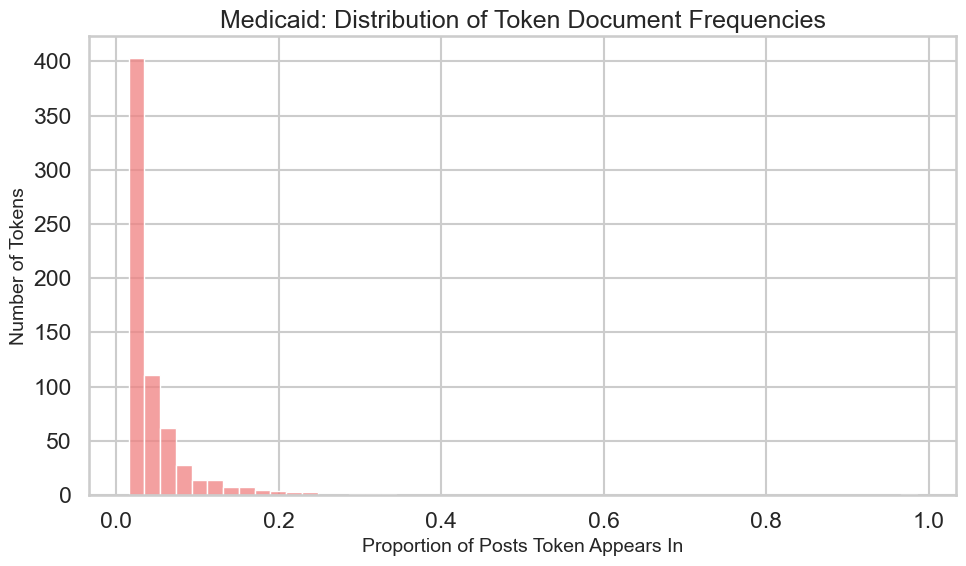

Figure saved as ../figures/medicaid_token_doc_freq.png


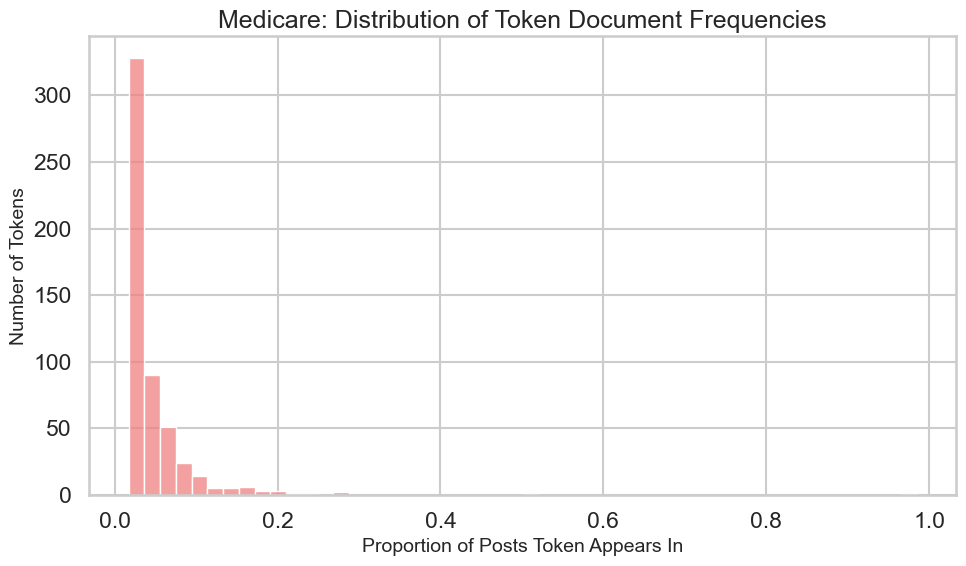

Figure saved as ../figures/medicare_token_doc_freq.png


In [61]:
# Token Document Frequencies
plot_token_doc_frequency(df_medicaid, text_column="clean_text", program_name="Medicaid")
plot_token_doc_frequency(df_medicare, text_column="clean_text", program_name="Medicare")

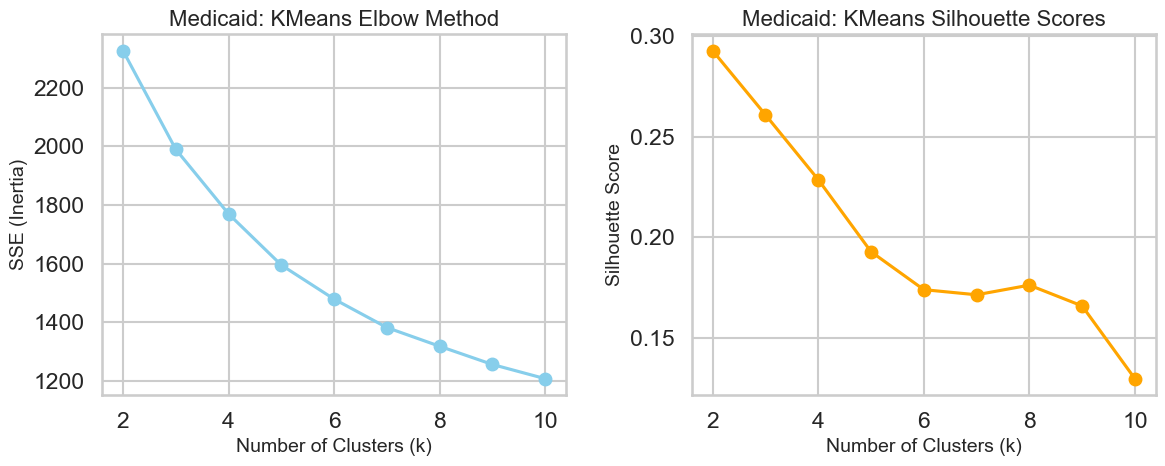

Figure saved as ../figures/medicaid_kmeans_eval.png


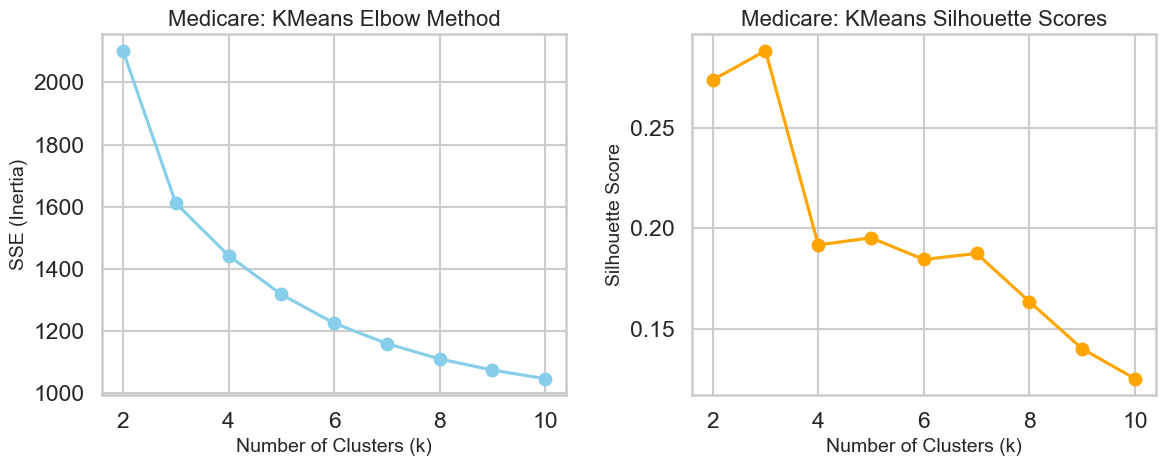

Figure saved as ../figures/medicare_kmeans_eval.png


In [62]:
# For X_combined, use your TF-IDF + numeric features matrix (sparse matrix or array)
kmeans_elbow_silhouette(X_combined_medicaid, program_name="Medicaid")
kmeans_elbow_silhouette(X_combined_medicare, program_name="Medicare")

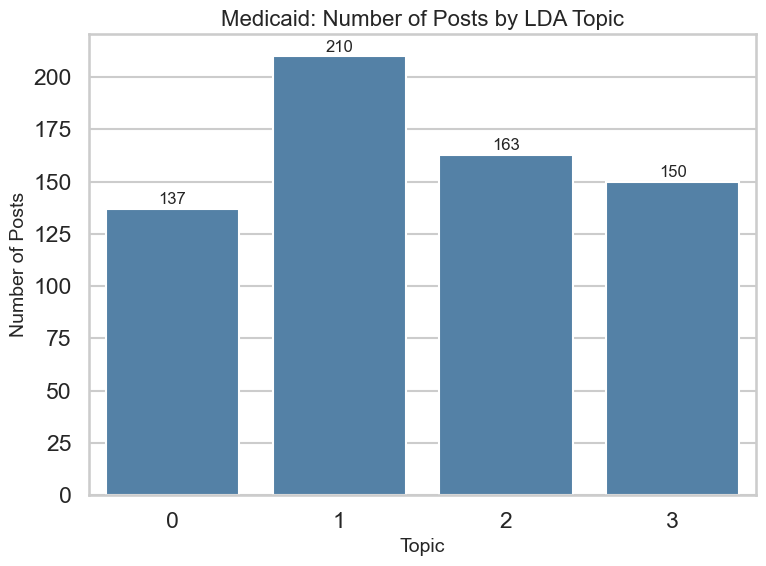

Figure saved as ../figures/medicaid_posts_by_topic.png


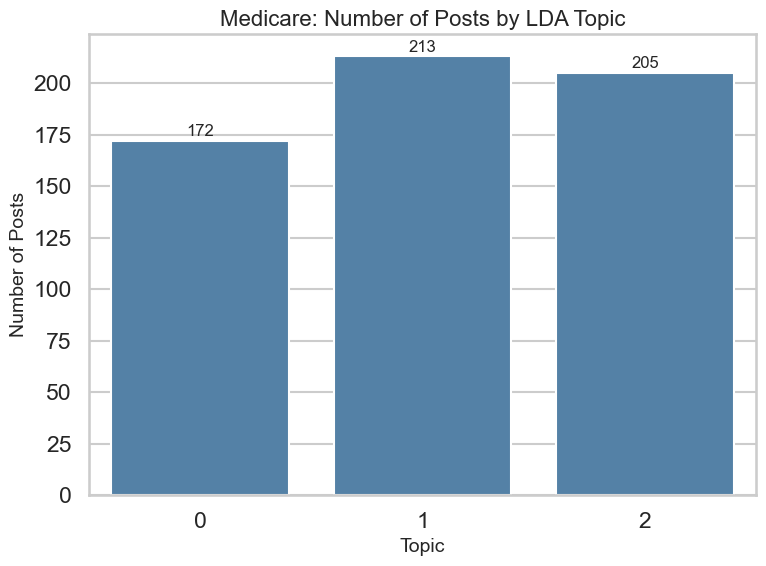

Figure saved as ../figures/medicare_posts_by_topic.png


In [63]:
# LDA topics
plot_posts_by_topic(df_medicaid, topic_col='lda_topic', program_name="Medicaid")
plot_posts_by_topic(df_medicare, topic_col='lda_topic', program_name="Medicare")


Top words per topic for Medicaid:

===== Topic 0 =====
renewal (91.2107)
household (60.2143)
child (55.1324)
medi (53.2409)
medi cal (53.2409)
cal (53.2409)
kids (39.2211)
texas (37.3199)
form (36.7981)
recently (32.5707)


===== Topic 1 =====
letter (83.7175)
office (65.0895)
called (62.6852)
information (57.1339)
received (55.1277)
card (55.1097)
im (53.9460)
applied (53.5877)
days (51.4440)
week (49.9045)


===== Topic 2 =====
mom (67.6746)
nursing (66.0839)
issues (63.2304)
old (52.7334)
needs (52.5596)
mother (51.7608)
facility (50.8311)
term (49.7115)
trust (44.2373)
house (43.9767)


===== Topic 3 =====
disabled (66.0760)
ny (64.3733)
monthly (64.1169)
ssi (46.1641)
program (45.7709)
social (42.0273)
denied (38.8525)
ssdi (37.8898)
looking (35.6228)
parents (32.7016)


Figure saved as ../figures/medicaid_top_words_by_topic.png


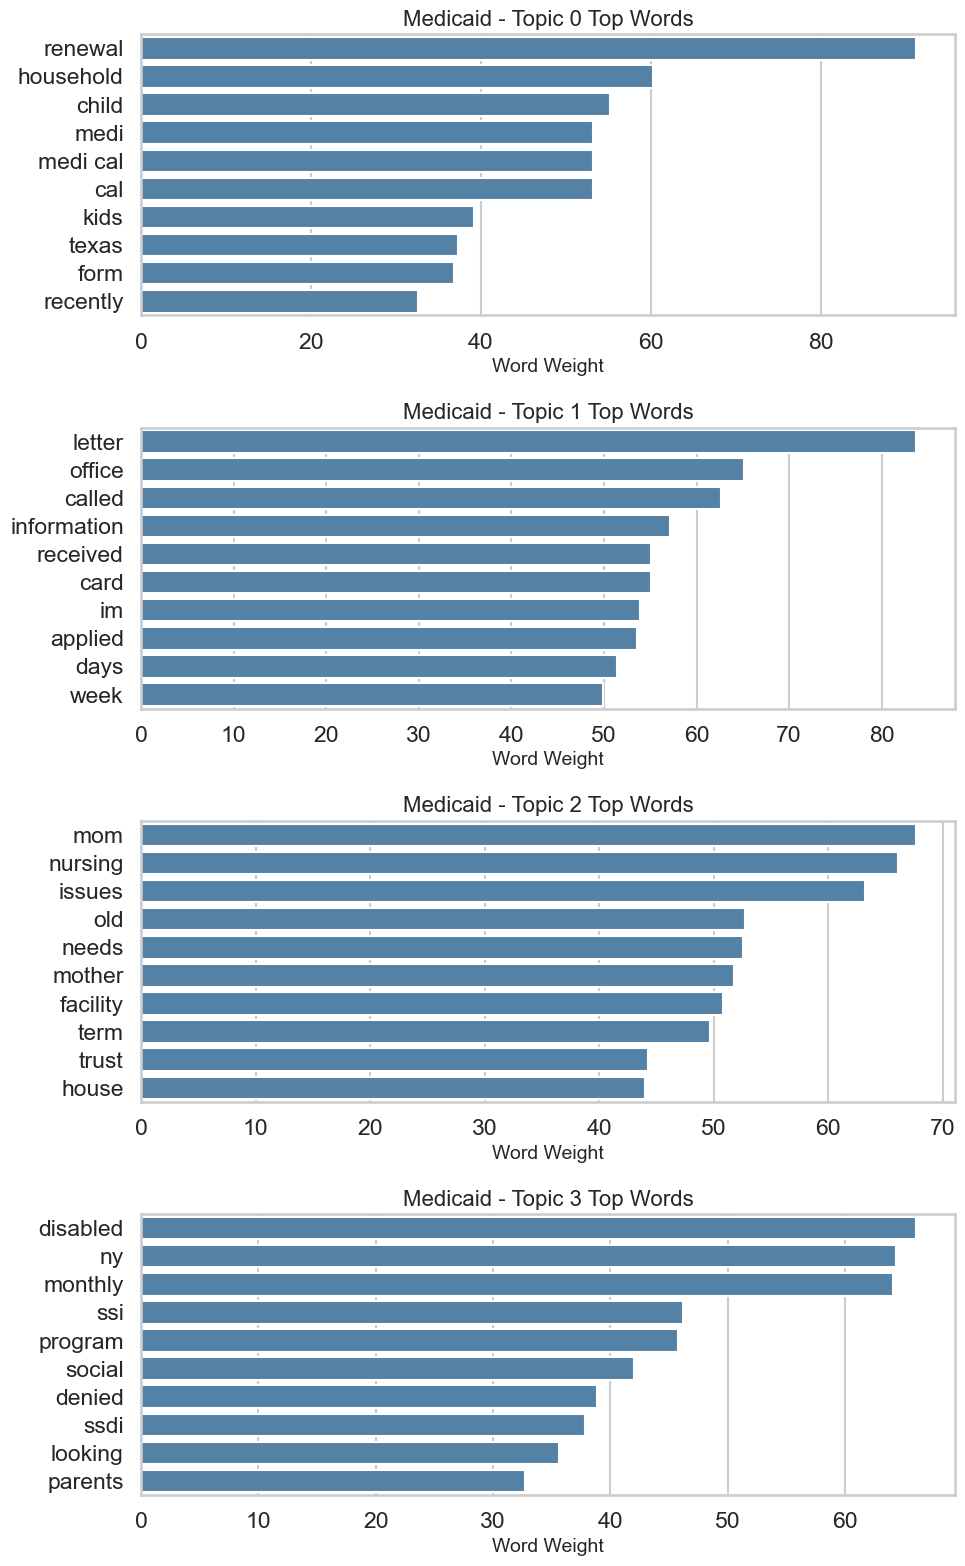


Topic summary for Medicaid:
    lda_topic  num_posts  avg_score  avg_num_comments  avg_text_length  \
0          0        137   1.766423          4.963504       550.934307   
1          1        210   2.033333          5.309524       761.790476   
2          2        163   2.300613          6.926380       793.552147   
3          3        150   1.966667          6.560000       687.380000   

   avg_word_count  
0      100.766423  
1      139.733333  
2      146.239264  
3      124.573333  


In [64]:
# Medicaid
df_medicaid, lda_medicaid, topic_summary_medicaid = fit_lda_and_plot(
    df_medicaid, program_name="Medicaid", n_topics=k_medicaid, n_top_words=10
)


Top words per topic for Medicare:

===== Topic 0 =====
irmaa (92.3227)
employer (68.3906)
social (66.3155)
security (65.3174)
social security (65.3174)
ssa (64.3099)
medicaid (56.9776)
letter (56.1054)
penalty (50.1477)
enrolled (48.5181)


===== Topic 1 =====
deductible (84.1828)
drug (79.8089)
cover (69.8051)
drugs (57.2186)
doctor (56.1349)
provider (52.6916)
humana (52.6002)
hospital (50.2886)
costs (49.9637)
paid (49.8214)


===== Topic 2 =====
gov (60.0387)
card (52.5188)
medigap plan (51.7758)
switch (51.3266)
medicare gov (50.2813)
bcbs (50.2644)
mom (49.9916)
issue (49.6935)
went (44.8298)
underwriting (40.2702)


Figure saved as ../figures/medicare_top_words_by_topic.png


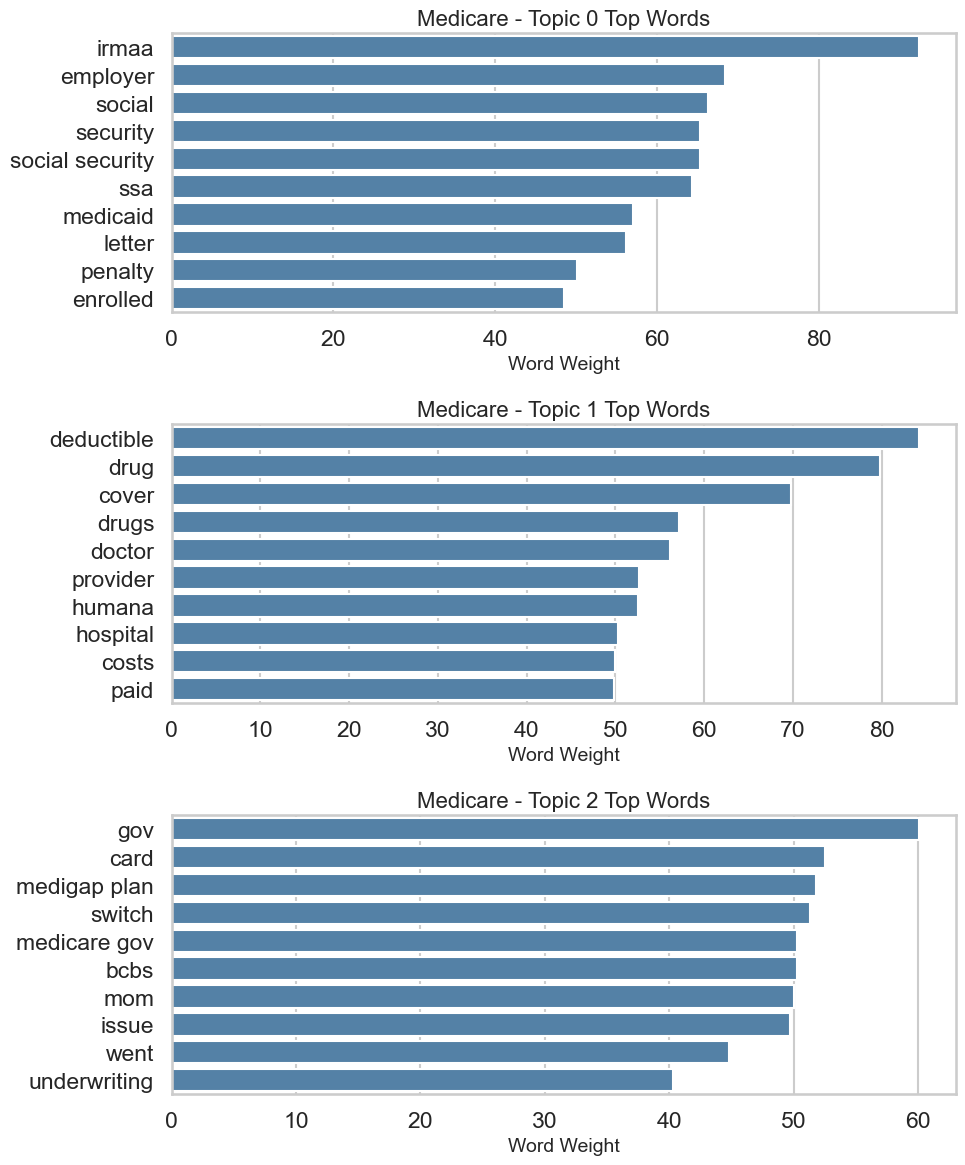


Topic summary for Medicare:
    lda_topic  num_posts  avg_score  avg_num_comments  avg_text_length  \
0          0        172   3.104651         12.069767       675.924419   
1          1        213   3.441315         15.065728       624.967136   
2          2        205   3.439024         14.780488       631.707317   

   avg_word_count  
0      122.691860  
1      109.131455  
2      114.404878  


In [65]:
# Medicare
df_medicare, lda_medicare, topic_summary_medicare = fit_lda_and_plot(
    df_medicare, program_name="Medicare", n_topics=k_medicare, n_top_words=10
)

Figure saved as ../figures/medicaid_engagement_by_topic.png


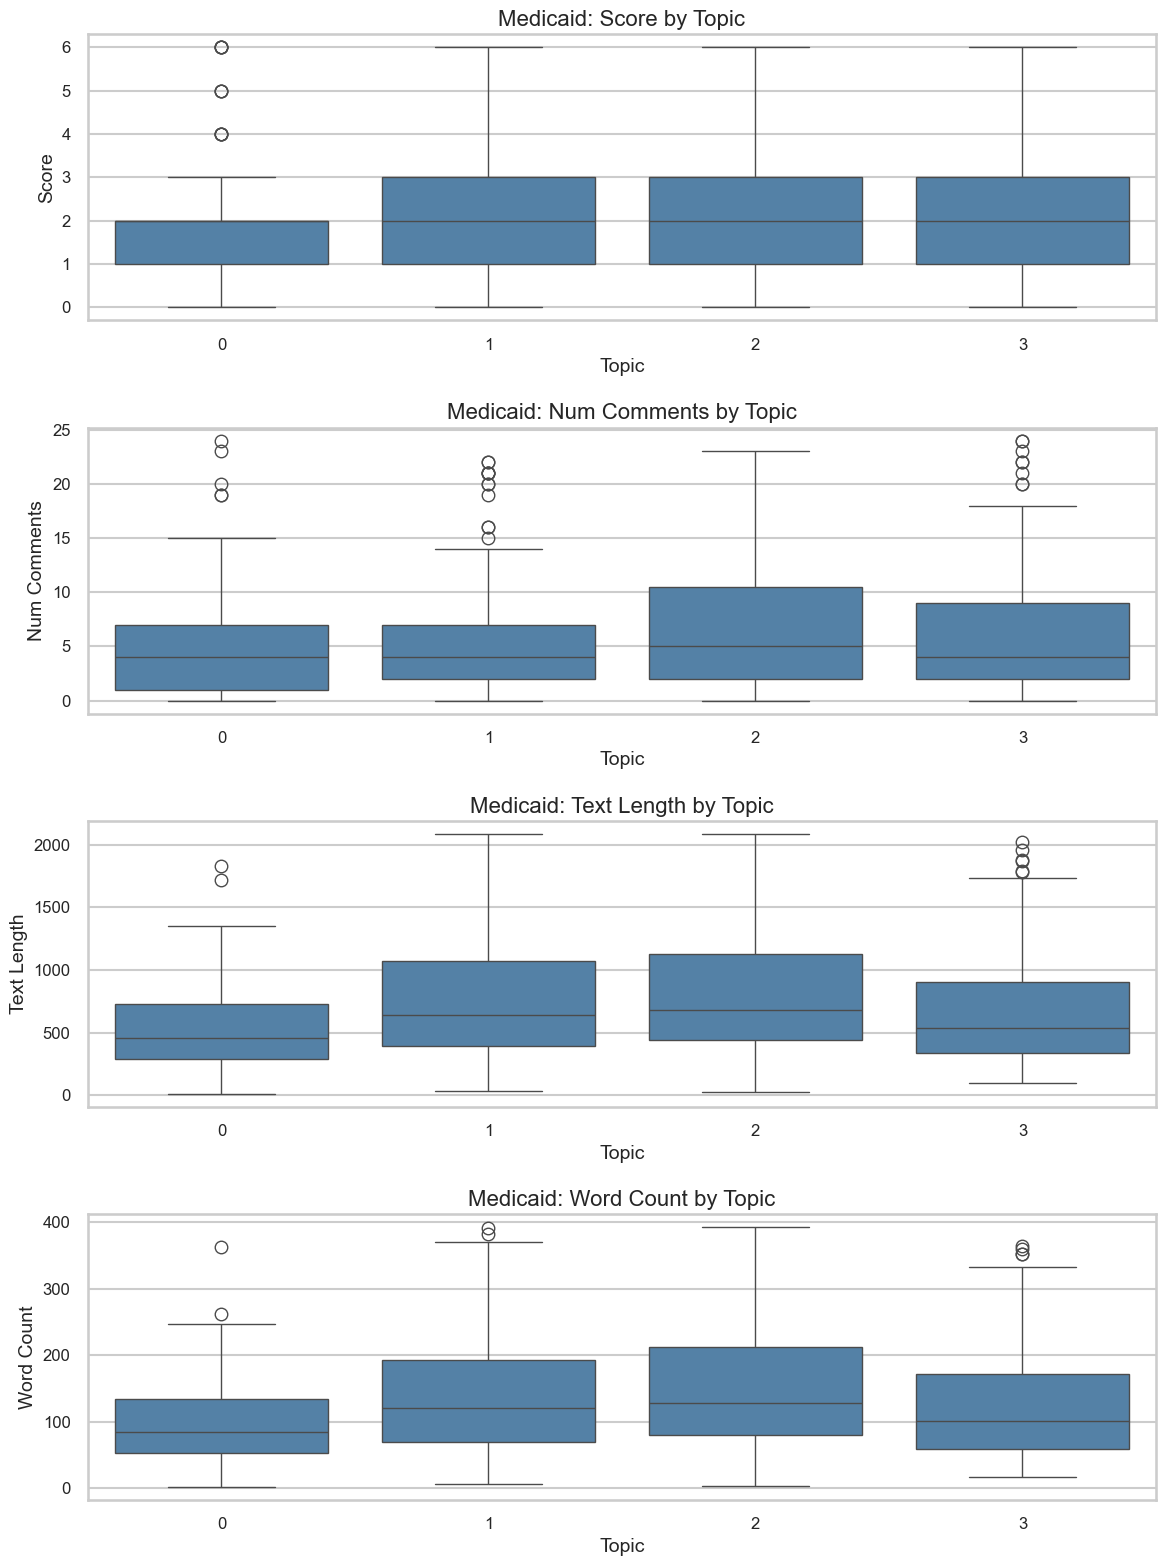

In [66]:
# Medicaid engagement distributions
plot_engagement_distributions(df_medicaid, program_name="Medicaid")

Figure saved as ../figures/medicare_engagement_by_topic.png


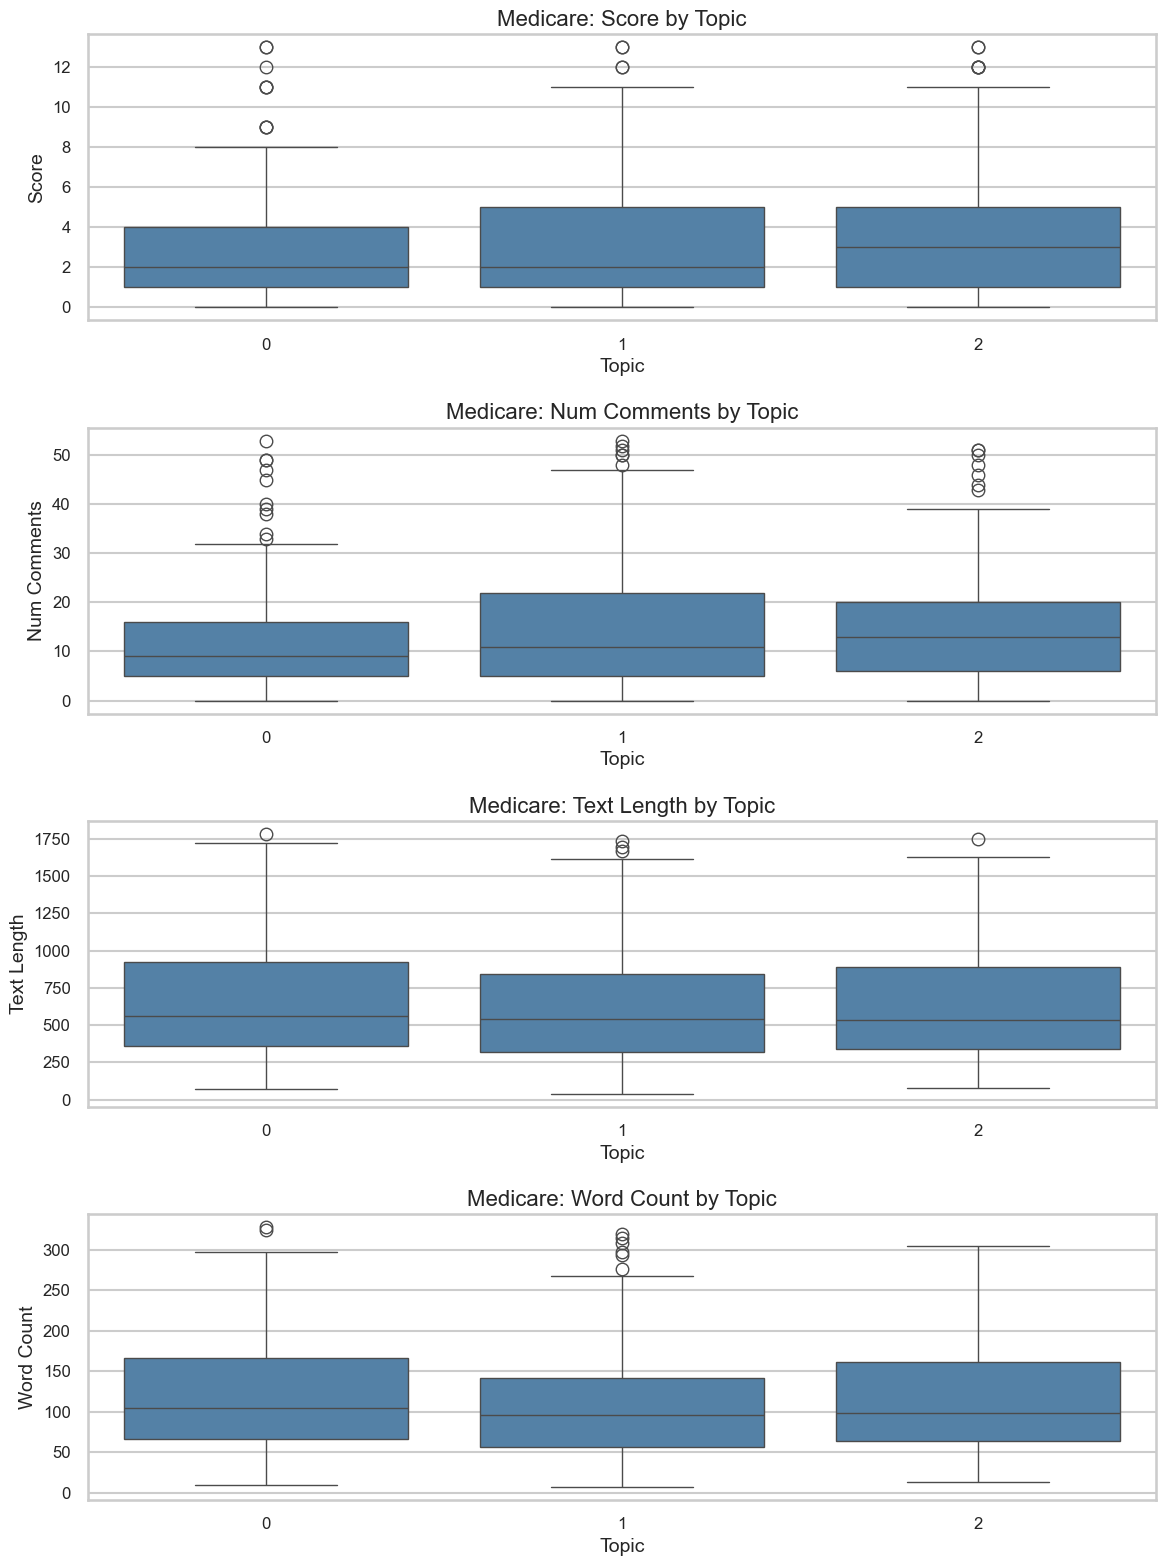

In [67]:
# Medicare engagement distributions
plot_engagement_distributions(df_medicare, program_name="Medicare")

Figure saved as ../figures/medicaid_kmeans_pca.png


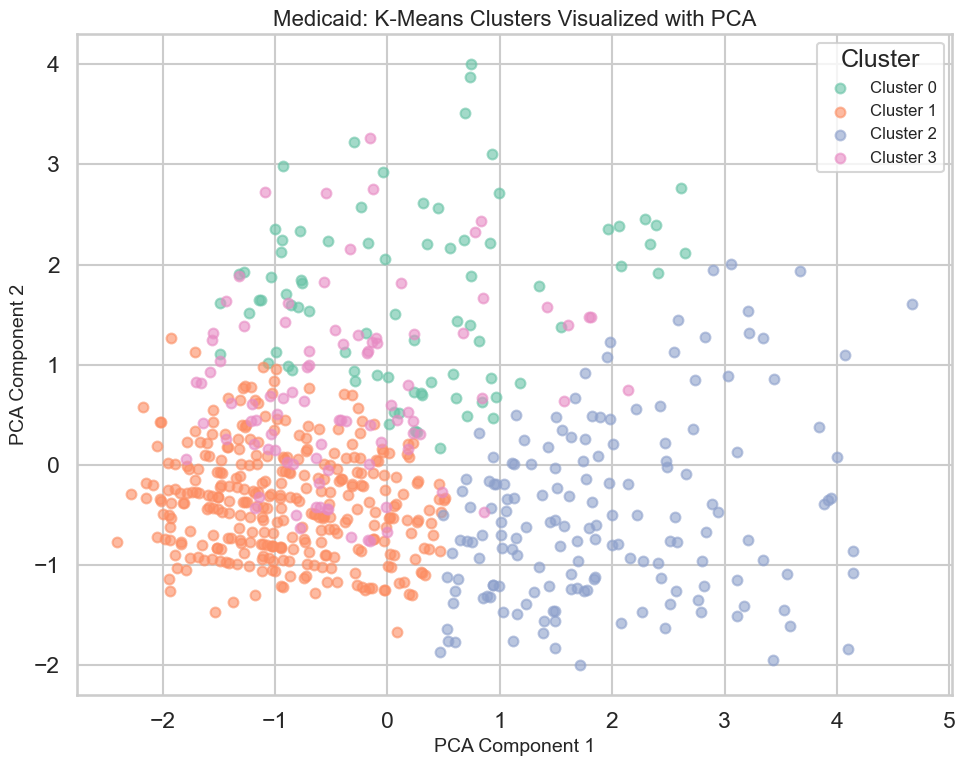

In [68]:
# Medicaid
plot_kmeans_pca(X_combined_medicaid.toarray(), df_medicaid, k=k_medicaid, program_name="Medicaid")

Figure saved as ../figures/medicare_kmeans_pca.png


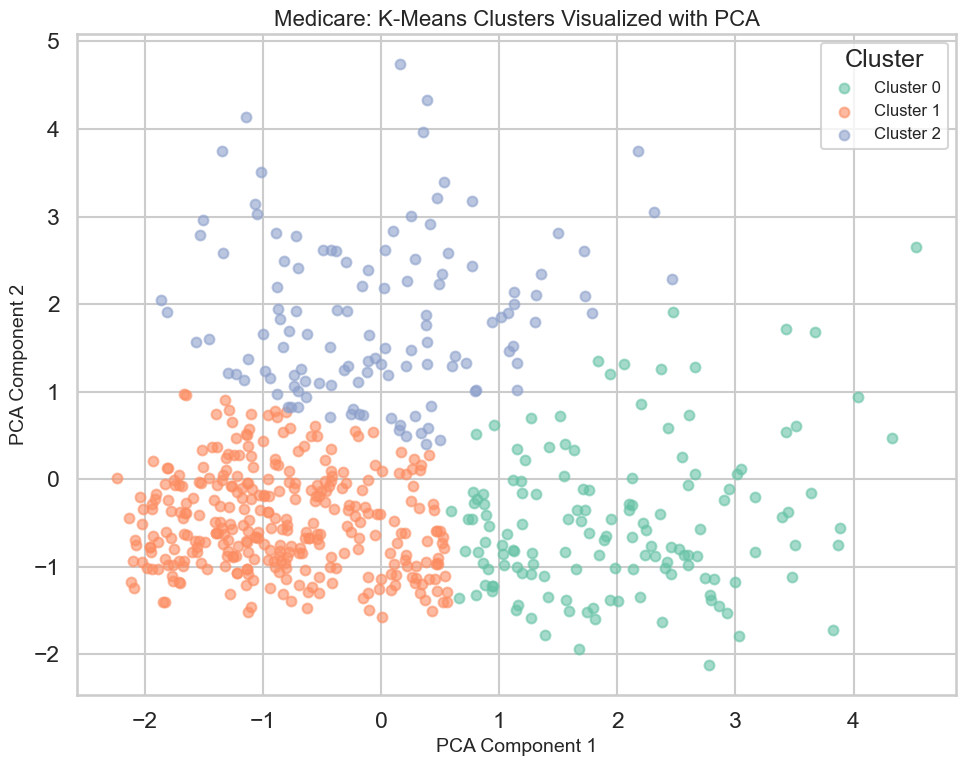

In [69]:
# Medicare
plot_kmeans_pca(X_combined_medicare.toarray(), df_medicare, k=k_medicare, program_name="Medicare")

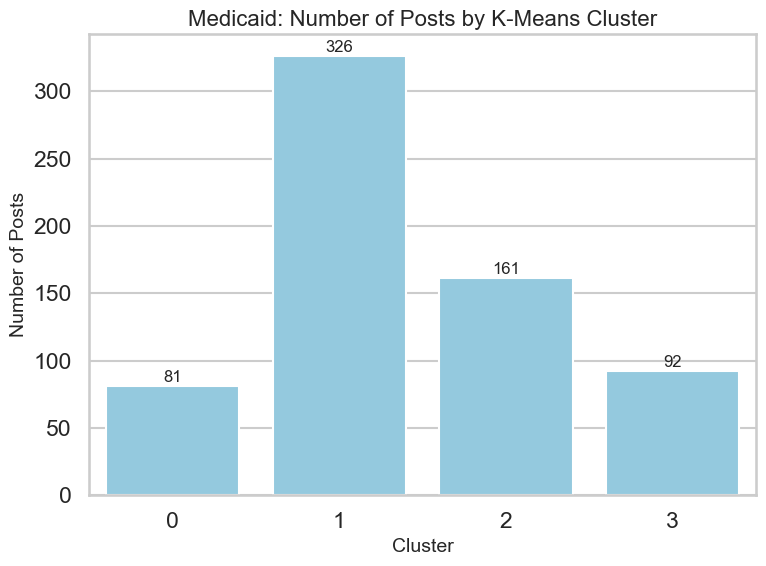

Figure saved as ../figures/medicaid_posts_by_cluster.png


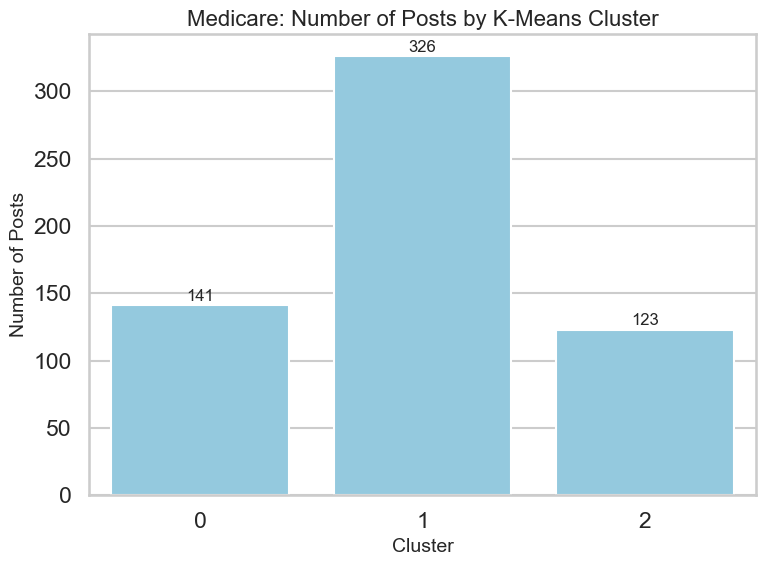

Figure saved as ../figures/medicare_posts_by_cluster.png


In [70]:
# Posts by cluster
plot_posts_by_cluster(df_medicaid, cluster_col='cluster', program_name="Medicaid")
plot_posts_by_cluster(df_medicare, cluster_col='cluster', program_name="Medicare")

Figure saved as ../figures/medicaid_engagement_by_cluster.png


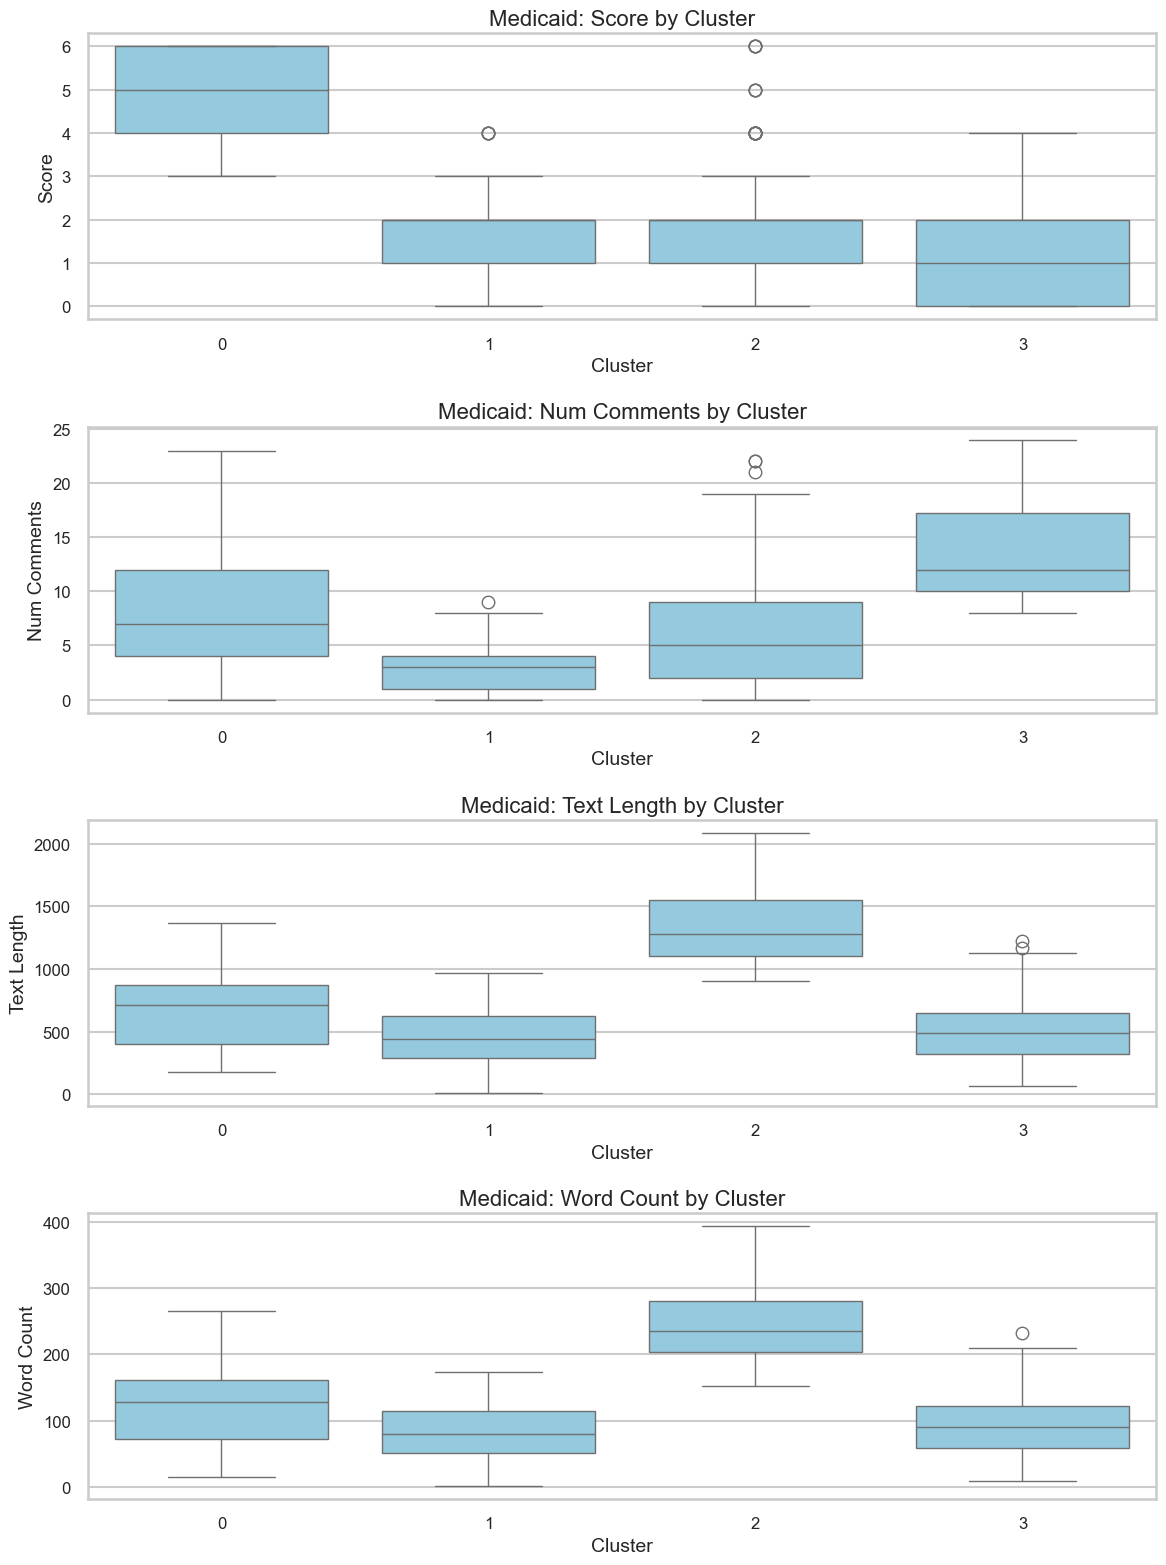

Figure saved as ../figures/medicare_engagement_by_cluster.png


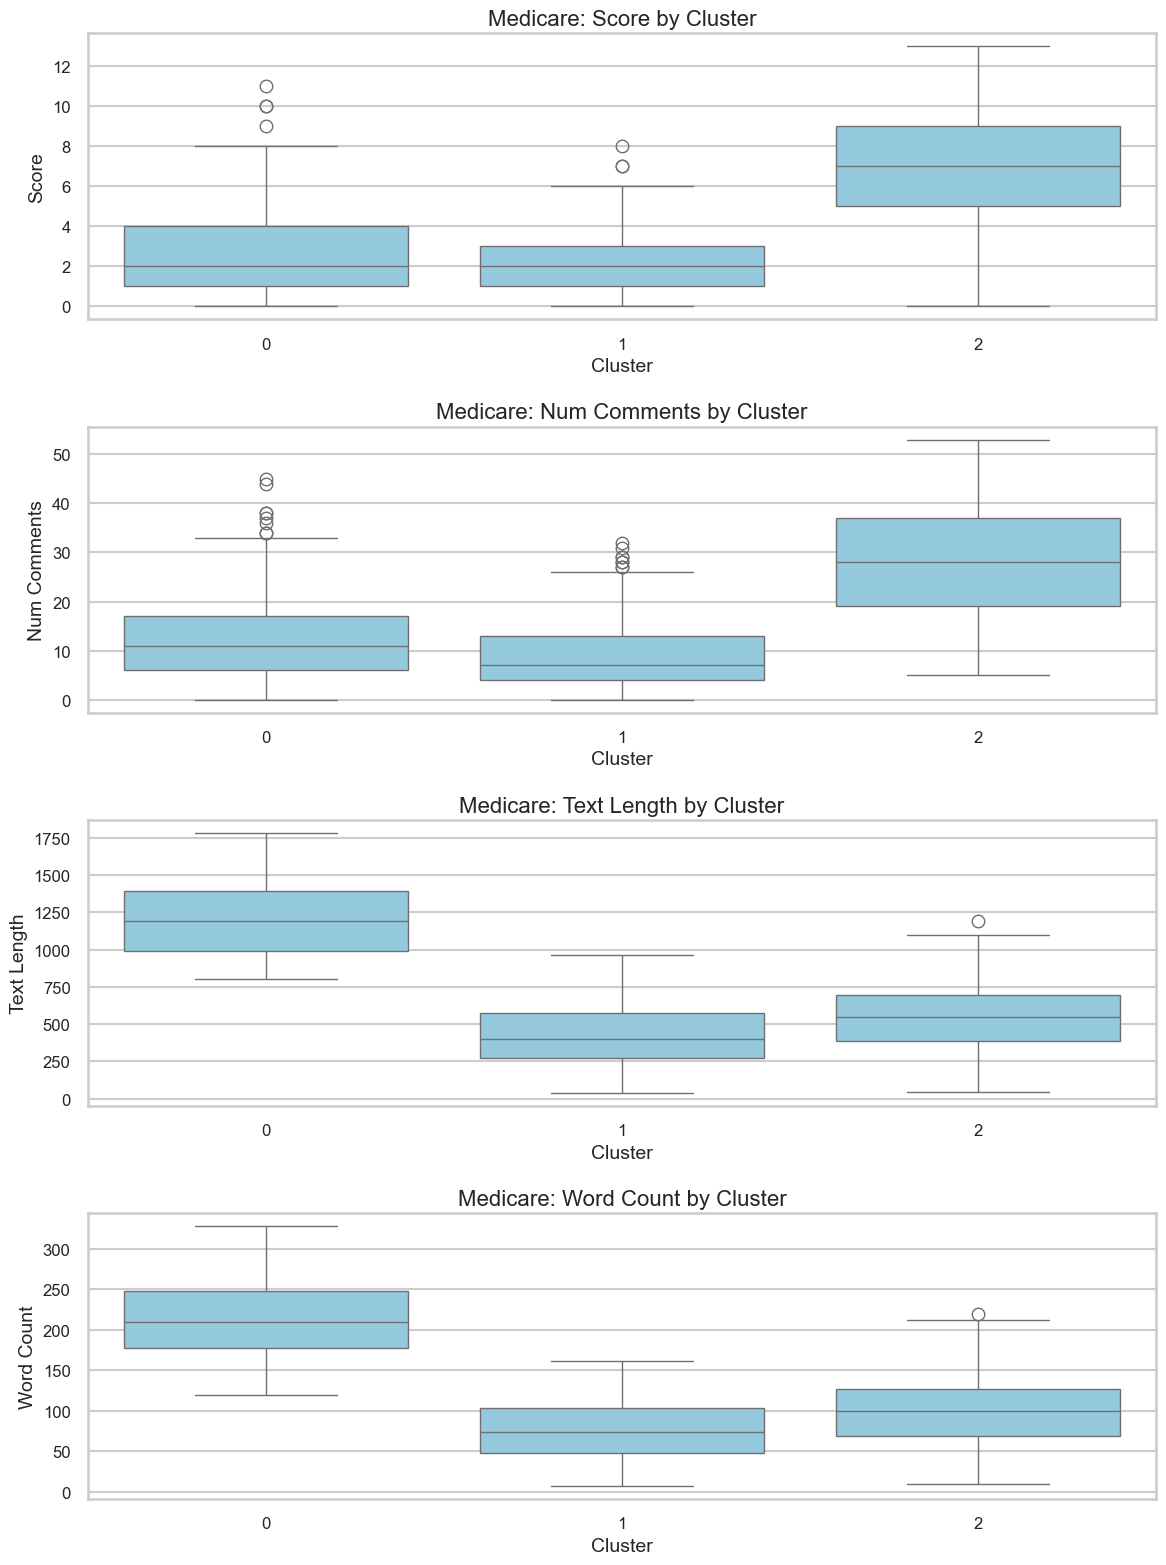

In [71]:
# Engagement by KMeans Cluster
plot_engagement_by_cluster(df_medicaid, cluster_col='cluster', program_name="Medicaid")
plot_engagement_by_cluster(df_medicare, cluster_col='cluster', program_name="Medicare")

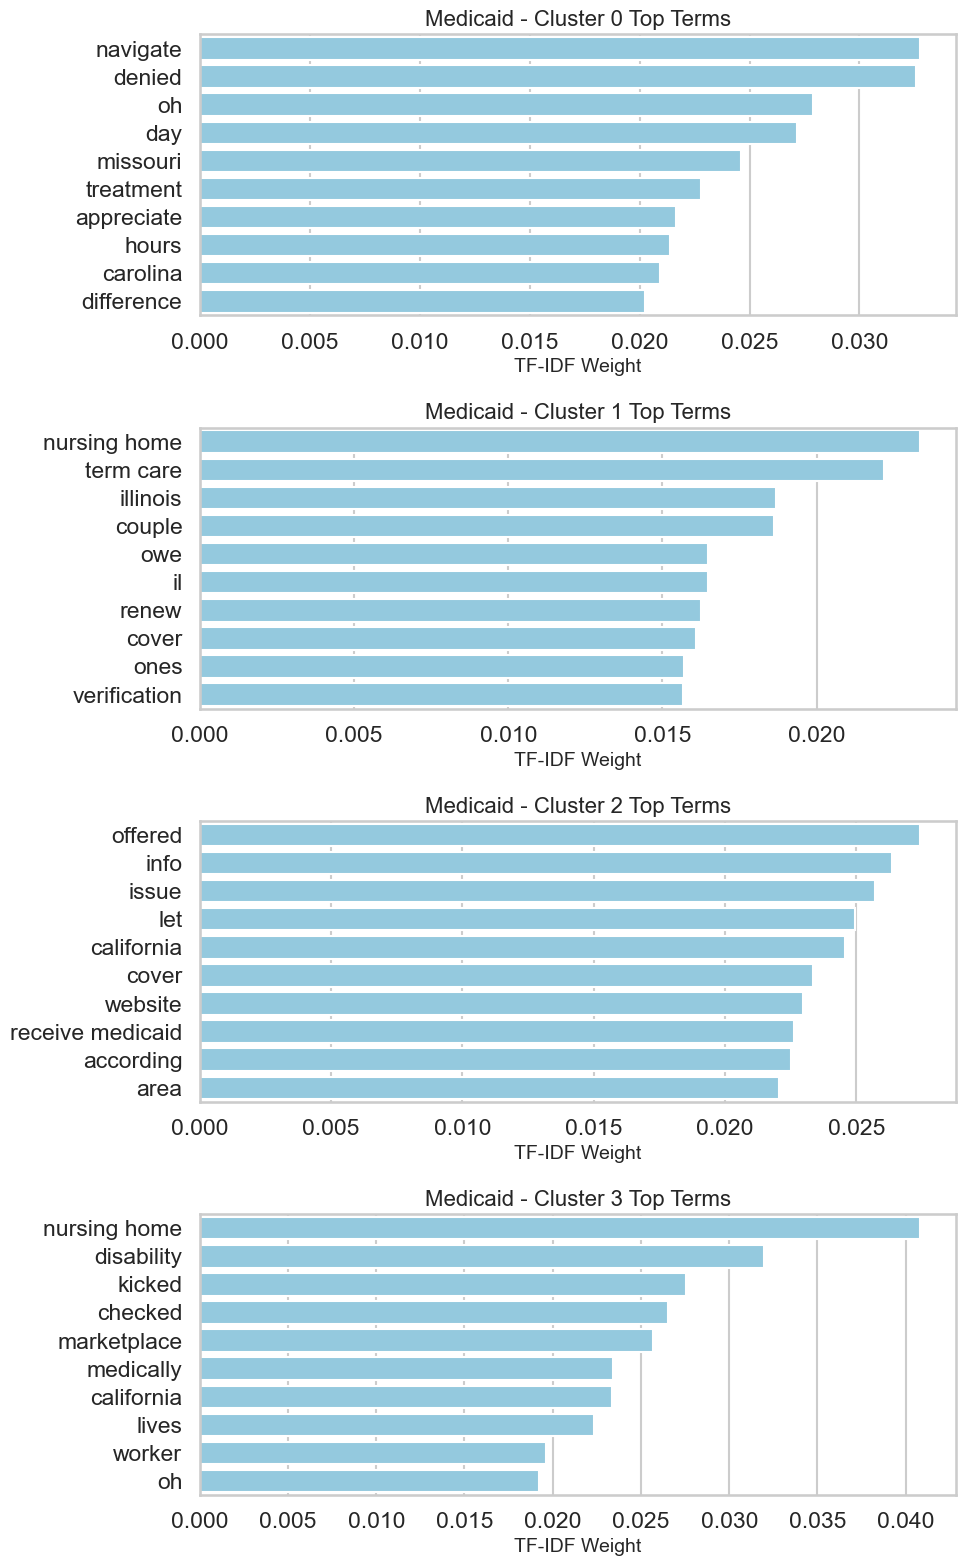

Figure saved as ../figures/medicaid_top_terms_by_cluster.png


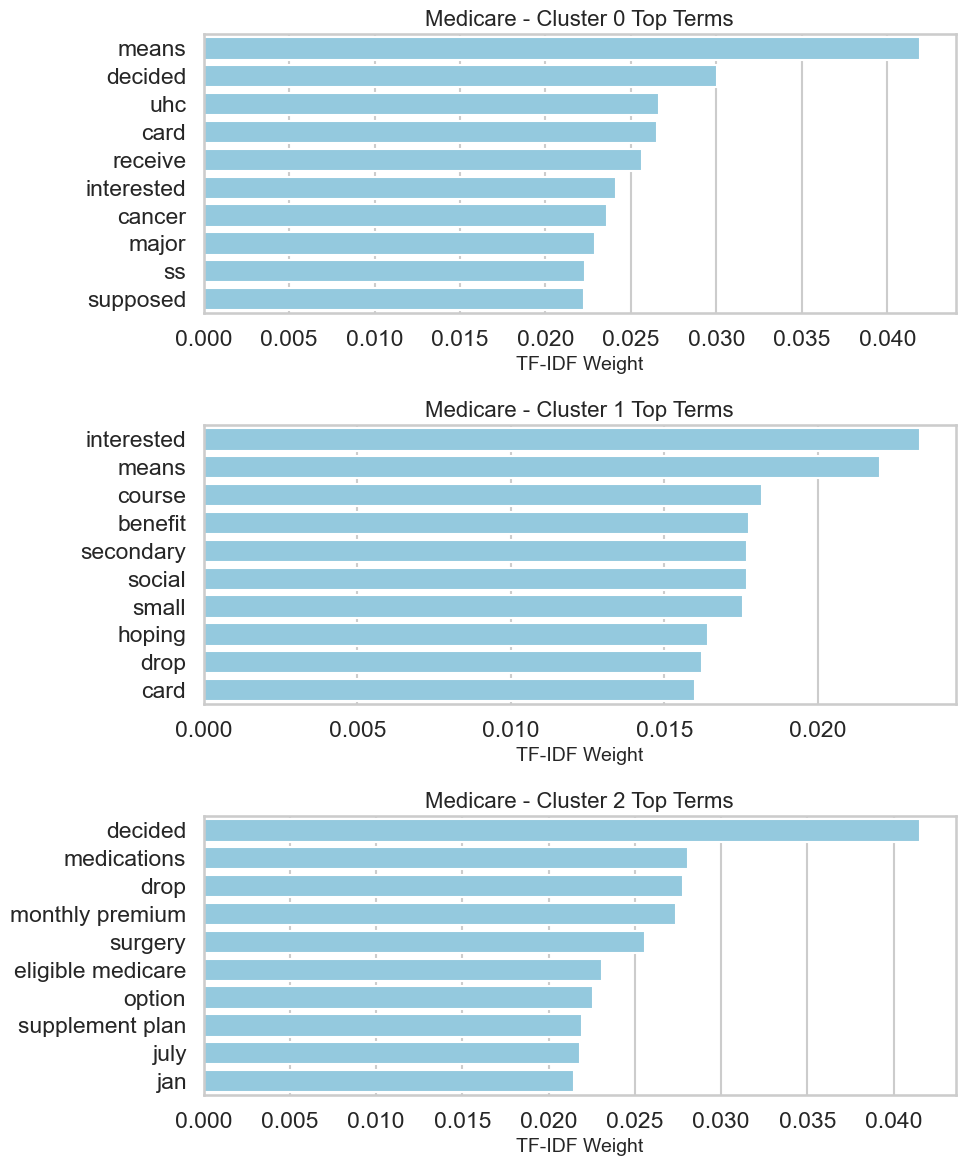

Figure saved as ../figures/medicare_top_terms_by_cluster.png


In [72]:
# Top terms by KMeans Cluster
plot_top_terms_per_cluster(df_medicaid, X_tfidf_only_medicaid, features_medicaid, numeric_cols, top_n=10, program_name="Medicaid")
plot_top_terms_per_cluster(df_medicare, X_tfidf_only_medicare, features_medicare, numeric_cols, top_n=10, program_name="Medicare")

## Export Data for Shiny Dashboard and Chatbot

In [73]:
# EXPORT DATA FOR SHINY DASHBOARD
OUT_DIR = "../data/shiny-data"
N_TOP_TERMS = 20
COOC_WINDOW = 5
EXAMPLES_PER_WORD = 5

os.makedirs(OUT_DIR, exist_ok=True)

In [74]:
# Topic-term matrix (long)
topic_term_matrix_medicare = lda_model_medicare.components_
topic_term_prob_medicare = topic_term_matrix_medicare / topic_term_matrix_medicare.sum(axis=1, keepdims=True)

rows = []
for t, row in enumerate(topic_term_prob_medicare):
    for i, w in enumerate(feature_names_medicare):
        rows.append({
            "topic": t,
            "term": w,
            "weight": float(row[i])
        })

topic_term_long_medicare = pd.DataFrame(rows)
topic_term_long_medicare.to_csv(f"{OUT_DIR}/topic_term_long.csv", index=False)

In [75]:
# Top terms per topic (wide)
top_rows = []
for t, row in enumerate(topic_term_matrix_medicare):
    top_idx = row.argsort()[::-1][:N_TOP_TERMS]
    for rank, idx in enumerate(top_idx, start=1):
        top_rows.append({
            "topic": t,
            "rank": rank,
            "term": feature_names_medicare[idx],
            "weight": float(row[idx])
        })

top_terms_df_medicare = pd.DataFrame(top_rows)
top_terms_df_medicare.to_csv(f"{OUT_DIR}/top_terms_by_topic.csv", index=False)

In [76]:
# Document-topic probabilities + metadata
doc_topic_probs_medicare = pd.DataFrame(
    topic_dist_medicare,
    columns=[f"topic_{i}" for i in range(k_medicare)]
)
doc_topic_probs_medicare.insert(0, "doc_id", df_medicare.index)
doc_topic_probs_medicare.to_csv(f"{OUT_DIR}/doc_topic_probs.csv", index=False)

docs_export_medicare = df_medicare.copy()
docs_export_medicare["doc_id"] = docs_export_medicare.index
docs_export_medicare.to_csv(f"{OUT_DIR}/documents.csv", index=False)

In [77]:
# Word co-occurrence matrix
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\']', ' ', text)
    return text.split()

cooc = Counter()

for text in df_medicare["clean_text"]:
    toks = tokenize(text)
    L = len(toks)
    for i, w in enumerate(toks):
        start = max(0, i - COOC_WINDOW)
        end = min(L, i + COOC_WINDOW + 1)
        for j in range(start, end):
            if i == j:
                continue
            pair = tuple(sorted((w, toks[j])))
            cooc[pair] += 1

cooc_rows = []
for (w1, w2), count in cooc.items():
    cooc_rows.append({"word": w1, "neighbor": w2, "count": count})

cooc_df = pd.DataFrame(cooc_rows)
cooc_df.to_csv(f"{OUT_DIR}/cooccurrence.csv", index=False)

In [78]:
# Example contexts for each word
examples = defaultdict(list)

for doc_id, text in enumerate(df_medicare["text"]):
    clean = df_medicare.loc[doc_id, "clean_text"]
    toks = tokenize(clean)
    uniq = set(toks)

    for w in uniq:
        if len(examples[w]) < EXAMPLES_PER_WORD:
            snippet = text[:400]
            examples[w].append({"doc_id": doc_id, "snippet": snippet})

example_rows = []
for w, vals in examples.items():
    for v in vals:
        example_rows.append({
            "term": w,
            "doc_id": v["doc_id"],
            "example": v["snippet"]
        })

examples_df = pd.DataFrame(example_rows)
examples_df.to_csv(f"{OUT_DIR}/examples_by_word.csv", index=False)

print("✓ All data for Shiny exported to shiny_data/")

✓ All data for Shiny exported to shiny_data/


In [79]:
# EXPORT TF-IDF MATRIX FOR USER–DOCUMENT COSINE SIMILARITY
print("Generating TF-IDF matrix...")

# ---------------------------------------------------------
# Fit TF-IDF on clean text using SAME preprocessing as LDA
# ---------------------------------------------------------
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 1),
    stop_words="english"
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_medicare["clean_text"])

# -----------------------------------
# Save sparse matrix for Shiny
# -----------------------------------
save_npz(f"{OUT_DIR}/tfidf_sparse.npz", tfidf_matrix)

# -----------------------------------
# Save feature names
# -----------------------------------
with open(f"{OUT_DIR}/tfidf_feature_names.json", "w") as f:
    json.dump(tfidf_vectorizer.get_feature_names_out().tolist(), f)

# -----------------------------------
# Precompute document norms (faster cosine similarity)
# -----------------------------------
doc_norms = np.sqrt(tfidf_matrix.multiply(tfidf_matrix).sum(axis=1)).A1

pd.DataFrame({
    "doc_id": df_medicare.index,
    "norm": doc_norms
}).to_csv(f"{OUT_DIR}/tfidf_doc_norms.csv", index=False)

print("✓ TF-IDF data exported for cosine similarity!")

Generating TF-IDF matrix...
✓ TF-IDF data exported for cosine similarity!
